In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


tsv_files = [f"combined_R1_tsv_files/{i}_S{i}_L001_R1_001.insertions.5p.tsv" for i in range(1, 121)]
guideRNA = pd.read_csv('FinalGuides_251218_260117_260203_combined.csv')

In [2]:
guideRNA

,Unnamed: 0,protospacer,sample
0,0,CTGACAATGGCAGATCCCAG,251218
1,1,TCGCACAGCGTGTACCACAG,251218
2,2,GTGAGCGAGTAACAACCCGT,251218
3,3,AATCCCGAATCTCTATCGTG,251218
4,4,ACGCCAATGTCGTTATCCAG,251218
...,...,...,...
115,115,ATGAGCCTCATCTTCTGGCA,260203
116,116,TACATAAGAGCCCCTTGCAC,260203
117,117,CAACAAGTCAGGTTGCGAGA,260203
118,118,GAGACAACAATTAACGACGG,260203


In [3]:
def reverse_complement(seq):
    """Return the reverse complement of a DNA sequence."""
    complement = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(complement)[::-1]


def map_guide_to_genome(guide, genome):
    """
    Map a guide RNA (DNA alphabet) to a genome sequence.

    Parameters
    ----------
    guide : str
        Guide RNA sequence (DNA alphabet: A/C/G/T)
    genome : str
        Genome sequence (DNA alphabet)

    Returns
    -------
    hits : list of dict
        Each hit contains:
        - start: 0-based start index in genome
        - end:   end index (exclusive)
        - strand: '+' or '-'
        - sequence: matched genome sequence
    """
    guide = guide.upper()
    genome = genome.upper()

    rc_guide = reverse_complement(guide)
    guide_len = len(guide)

    hits = []

    # Search forward strand
    start = 0
    while True:
        idx = genome.find(guide, start)
        if idx == -1:
            break
        hits.append({
            "start": idx,
            "end": idx + guide_len,
            "strand": "+",
            "sequence": genome[idx:idx + guide_len]
        })
        start = idx + 1

    # Search reverse strand
    start = 0
    while True:
        idx = genome.find(rc_guide, start)
        if idx == -1:
            break
        hits.append({
            "start": idx,
            "end": idx + guide_len,
            "strand": "-",
            "sequence": genome[idx:idx + guide_len]
        })
        start = idx + 1

    return hits

def percent_within_distance(insertions, target_position, window_bp):
    """
    Compute the percentage of insertions within ±window_bp of a target position.

    Parameters
    ----------
    insertions : iterable of int
        Genomic coordinates of insertions (e.g., start positions).
    target_position : int
        Genomic coordinate to compare against.
    window_bp : int
        Distance window in base pairs (±window_bp).

    Returns
    -------
    percent : float
        Percentage of insertions within the window.
    """
    if len(insertions) == 0:
        return 0.0

    count_within = sum(
        abs(pos - target_position) <= window_bp
        for pos in insertions
    )

    return 100.0 * count_within / len(insertions)


In [4]:
import re
from Bio import SeqIO
gRNA = guideRNA['protospacer']
gRNA
genome_sequence = str(next(SeqIO.parse('cJP003_assembly.fasta', "fasta")).seq)
genome_sequence = re.sub(r'^>.*\n?','',genome_sequence,flags=re.MULTILINE)
genome_sequence = genome_sequence.replace('\n','').replace('\r','')
map_guide_to_genome(gRNA[0],genome_sequence)

[{'start': 2528550,
  'end': 2528570,
  'strand': '+',
  'sequence': 'CTGACAATGGCAGATCCCAG'}]

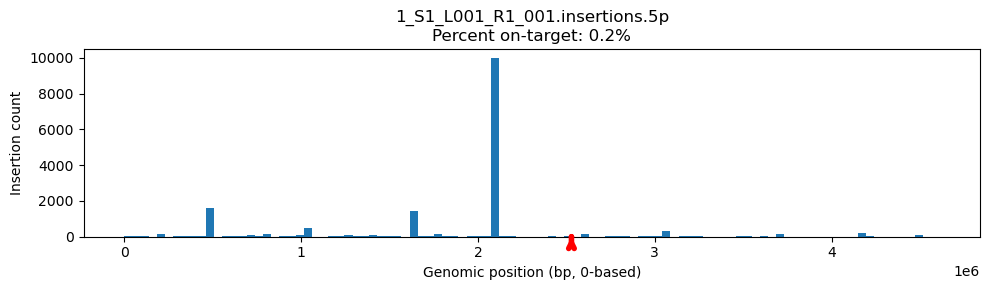

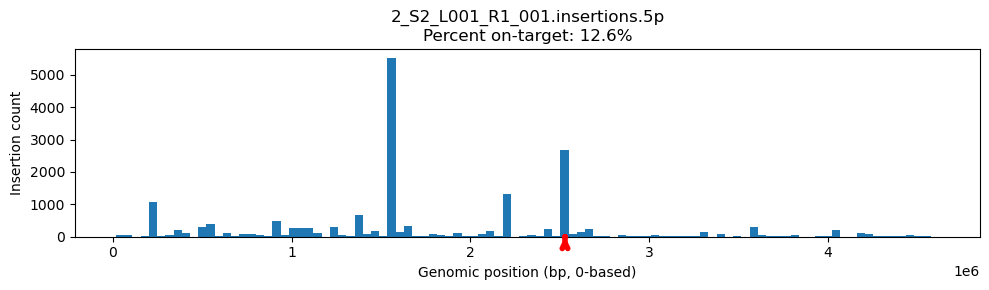

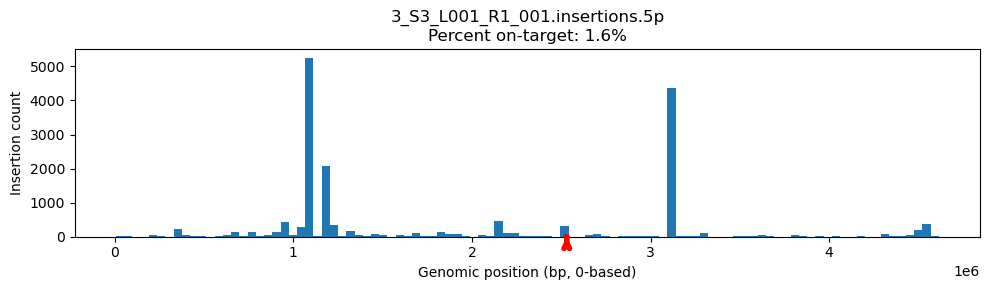

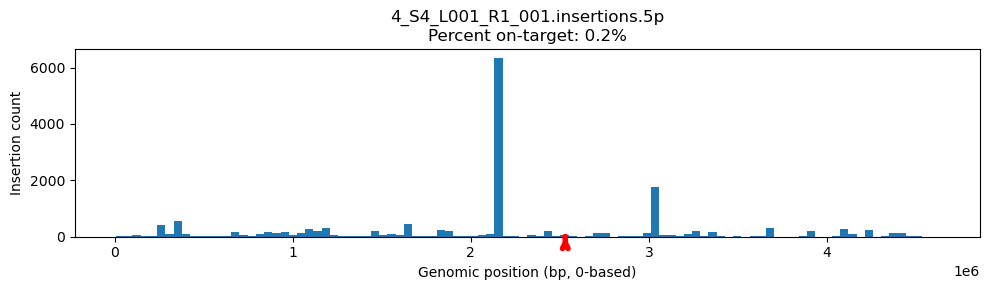

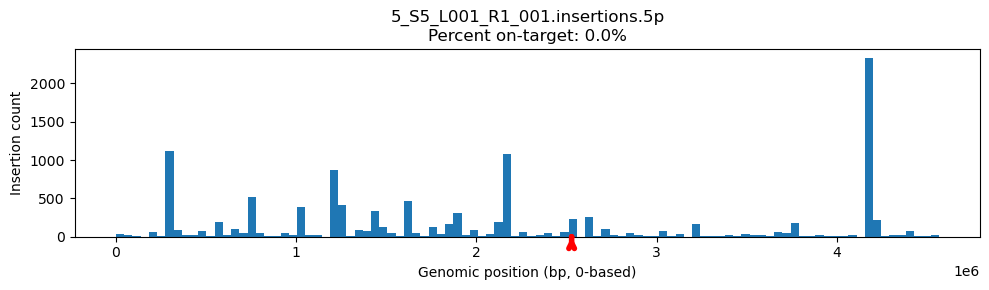

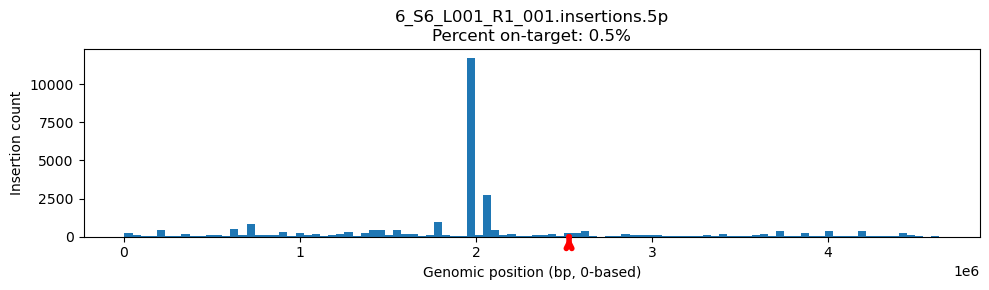

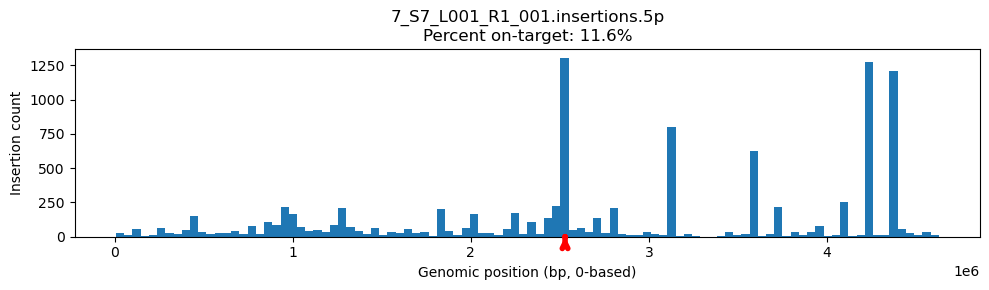

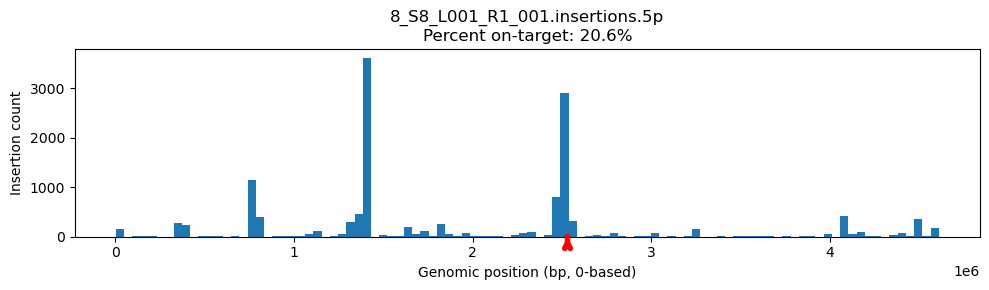

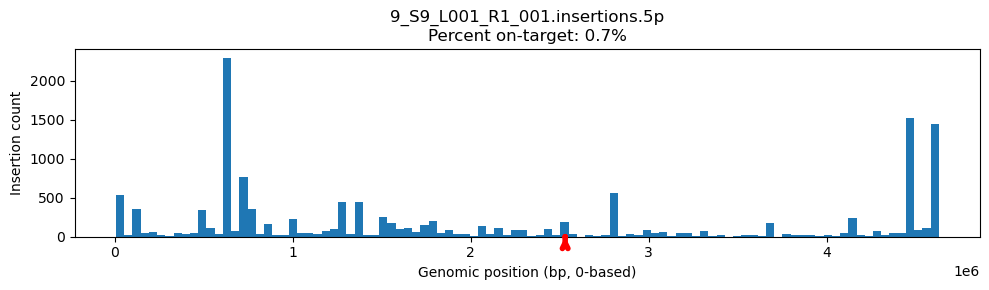

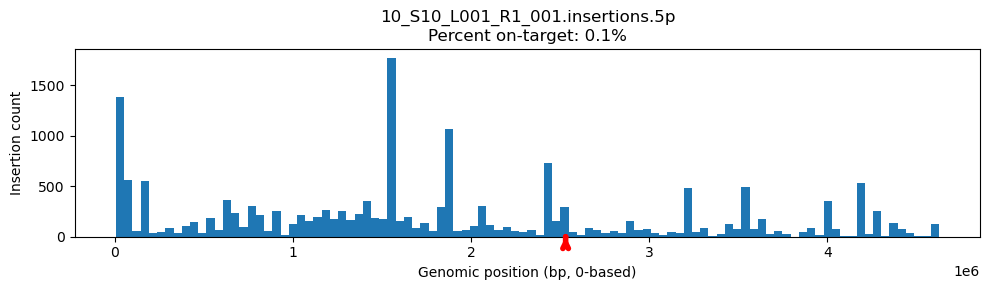

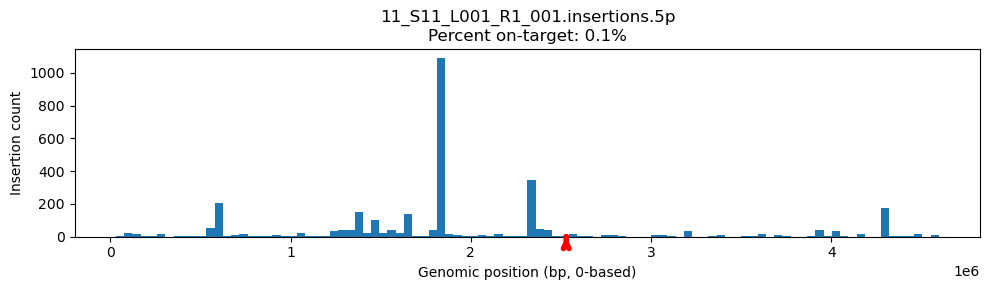

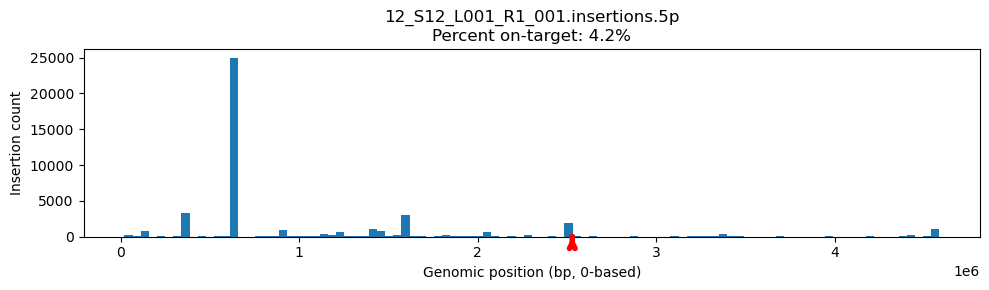

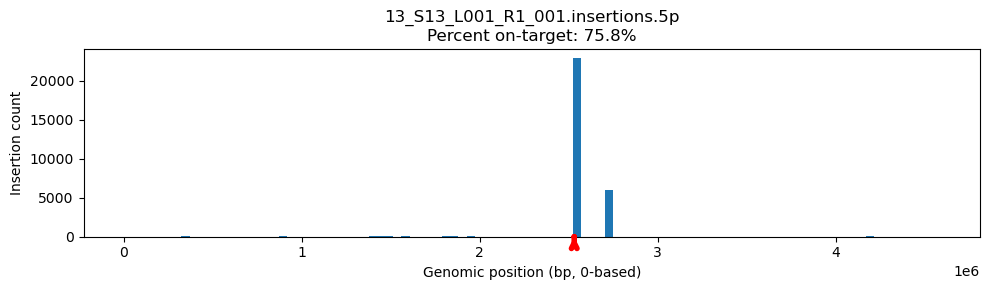

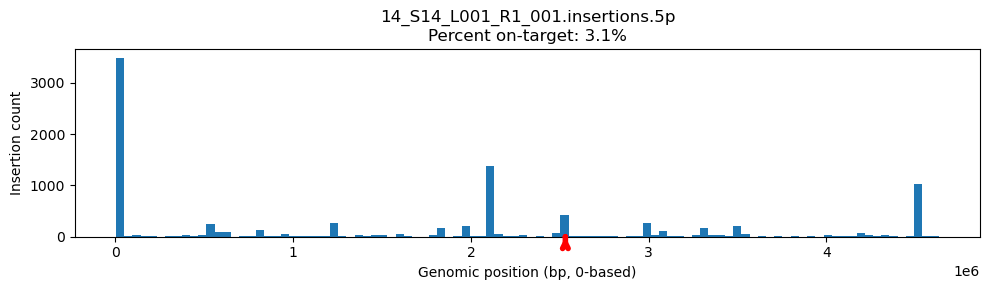

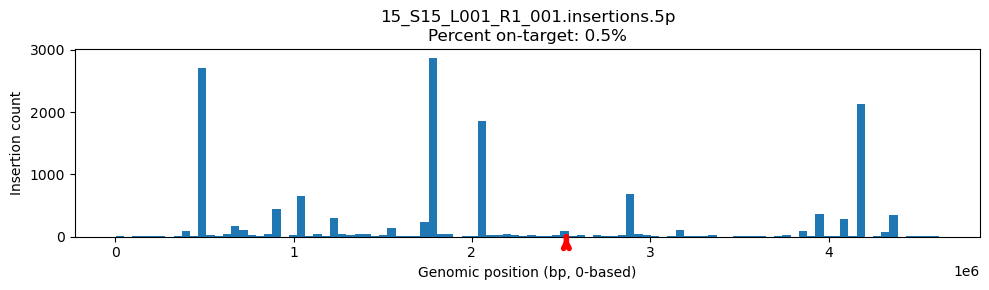

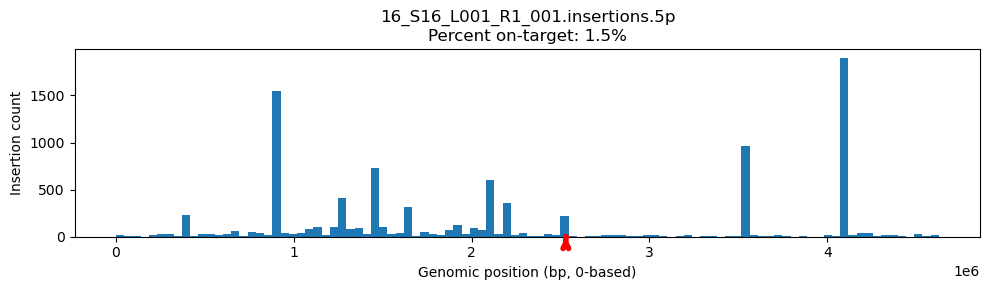

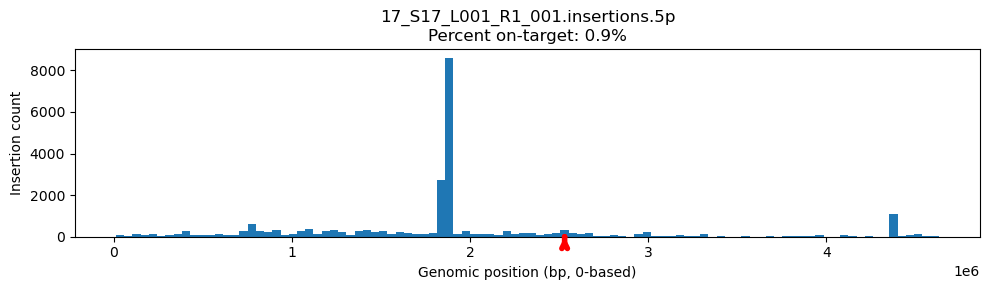

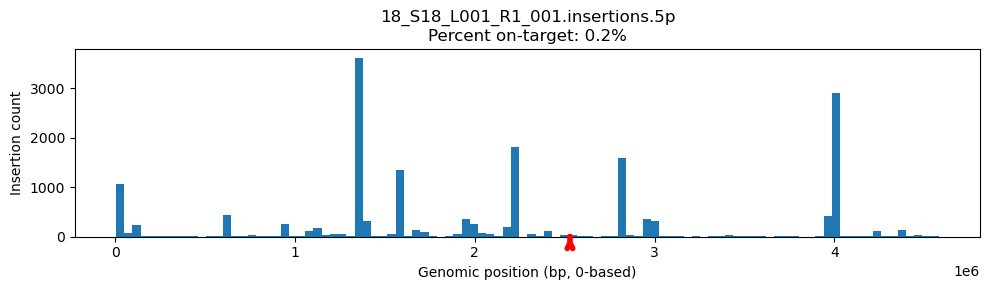

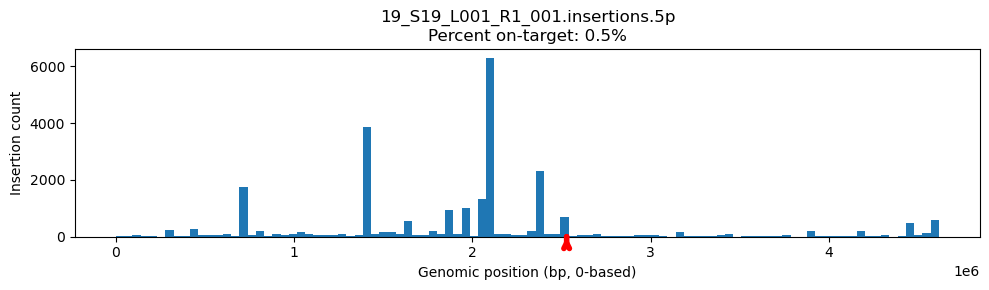

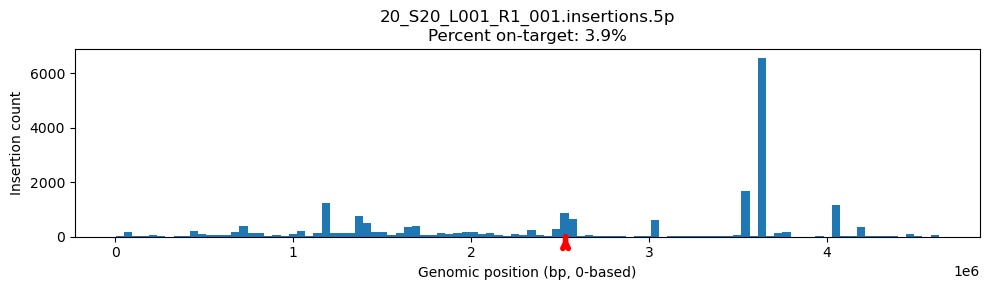

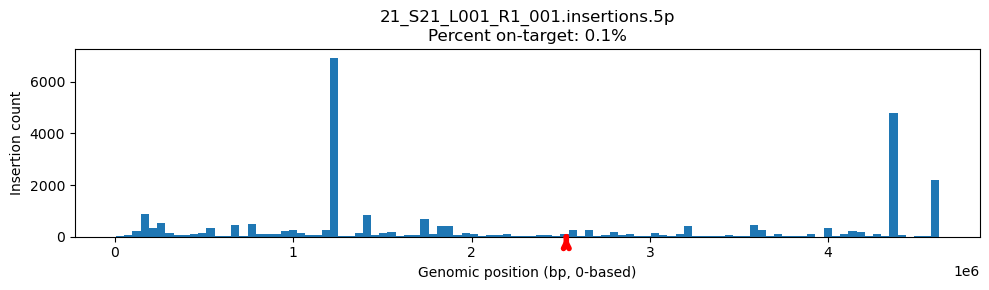

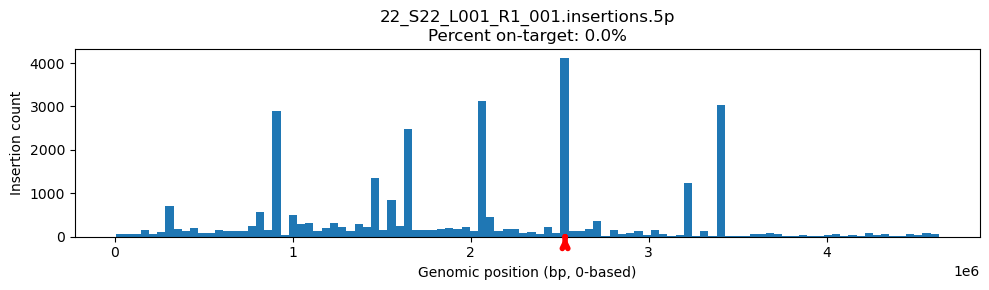

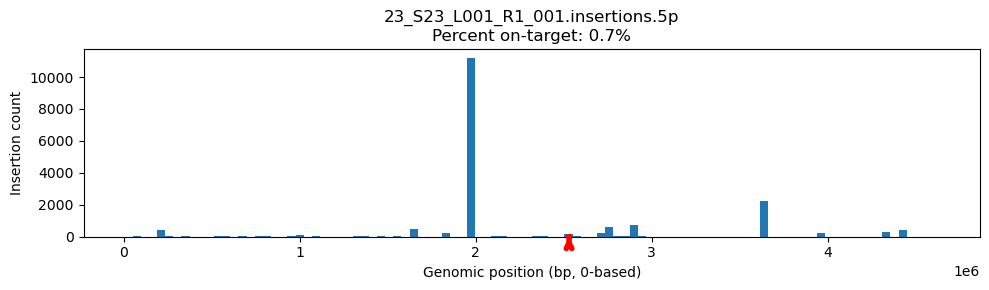

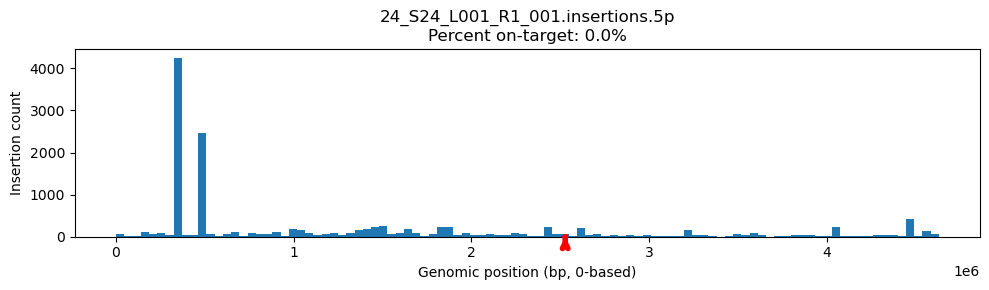

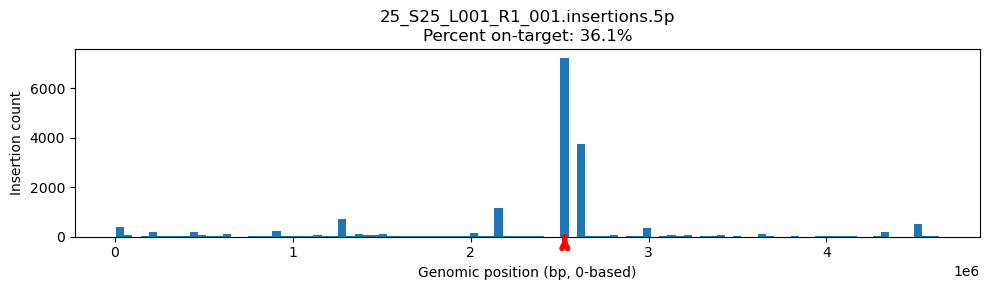

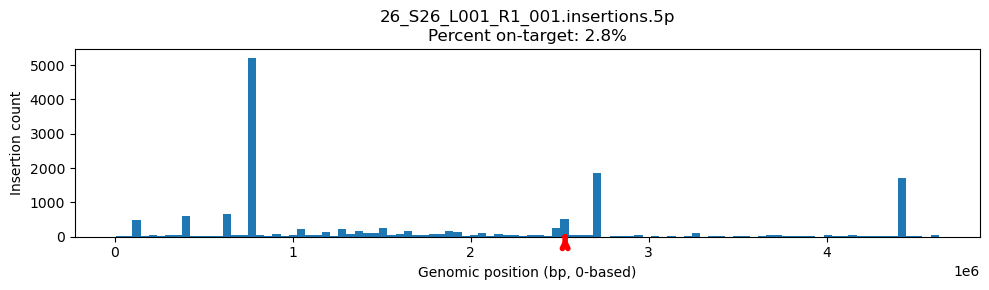

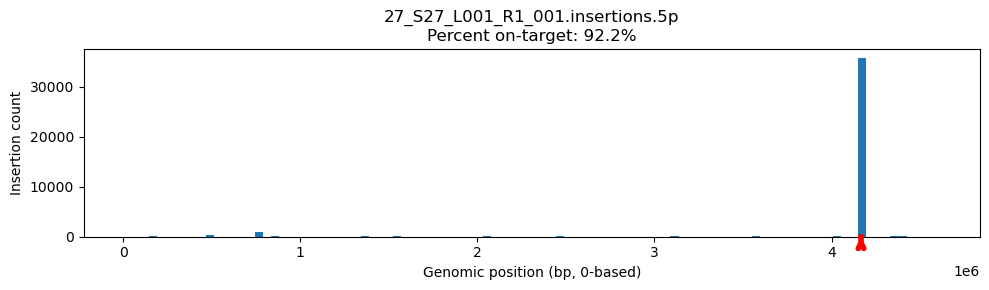

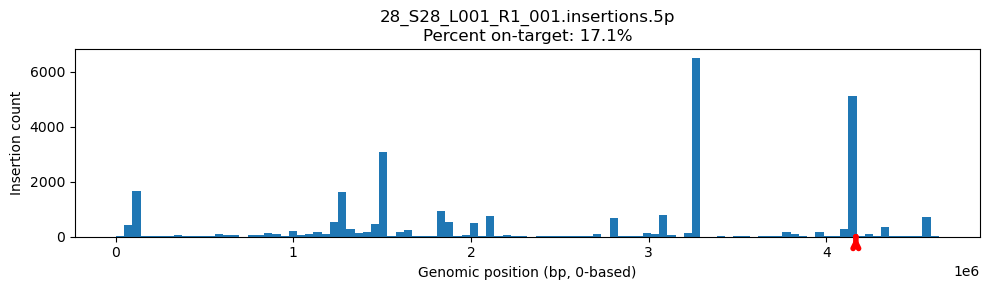

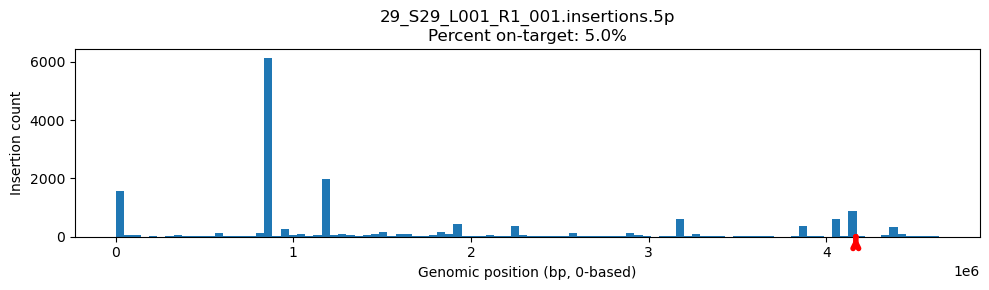

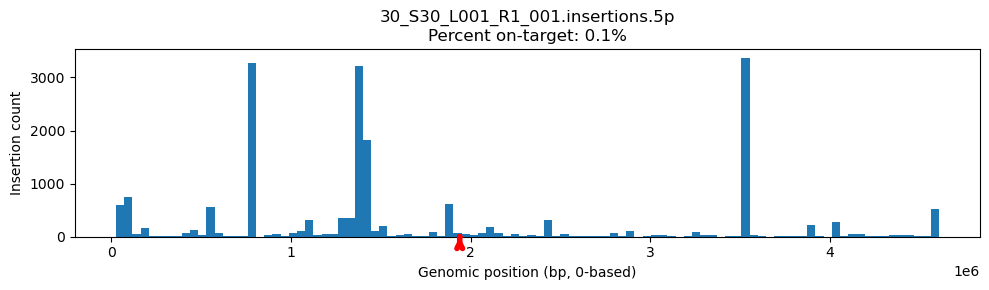

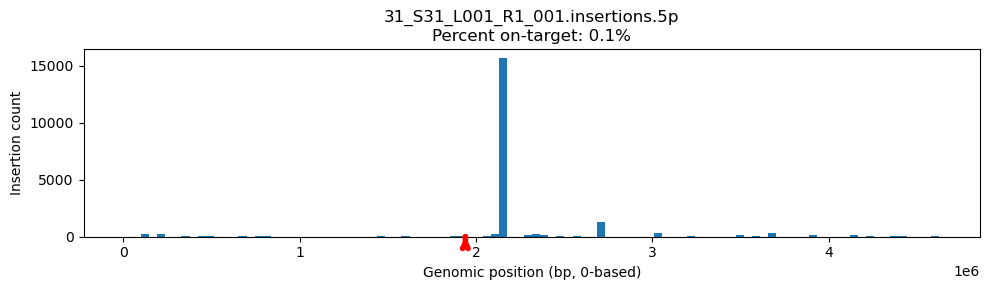

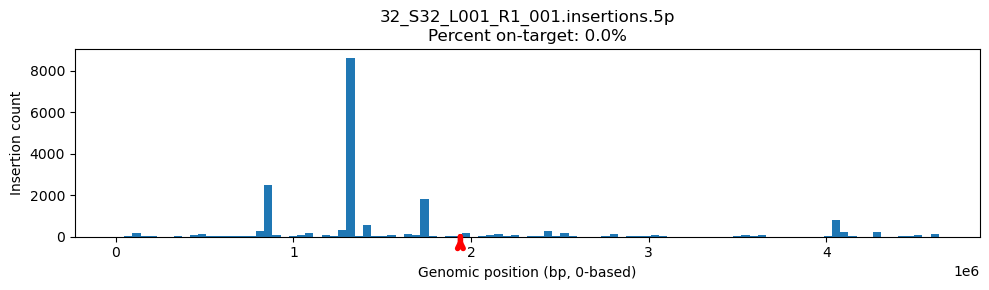

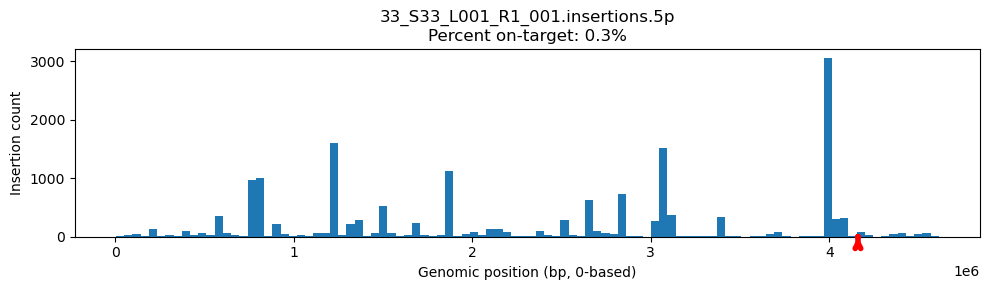

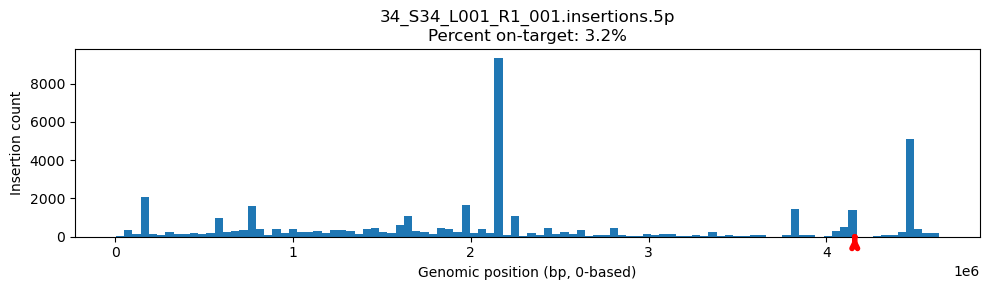

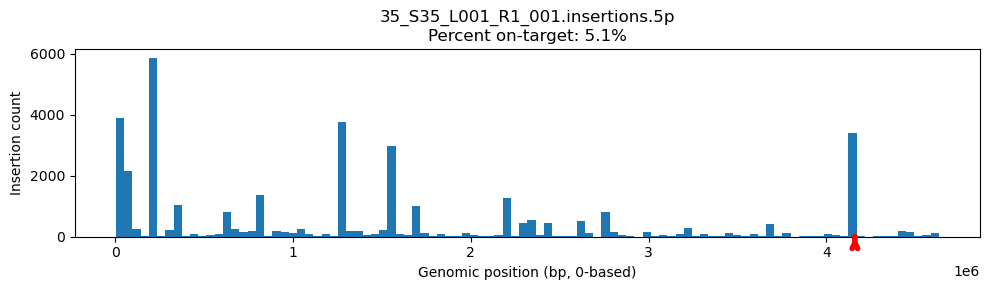

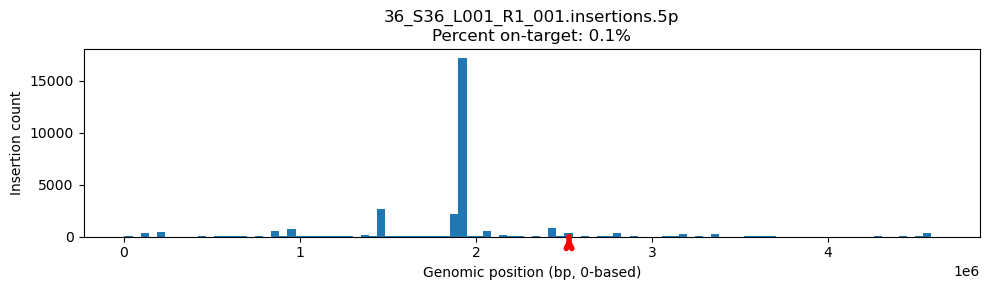

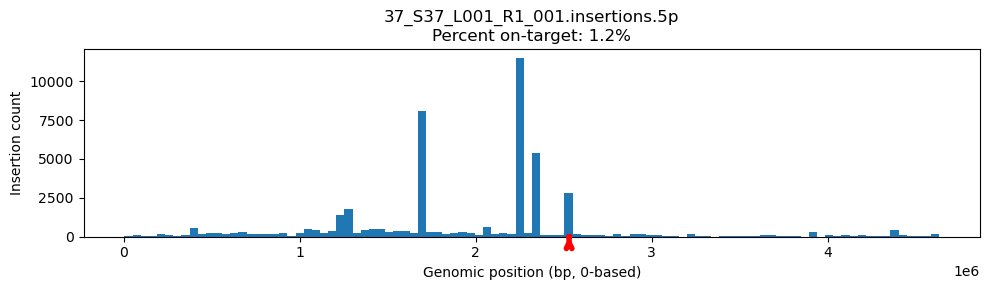

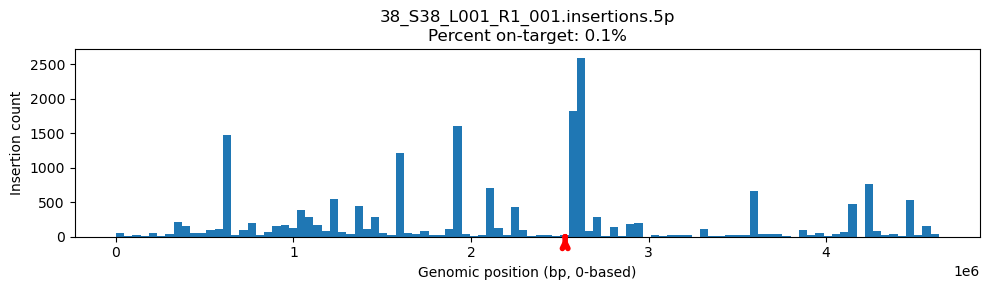

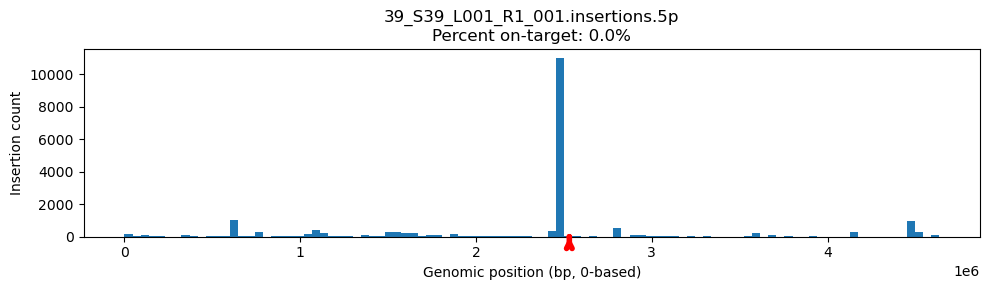

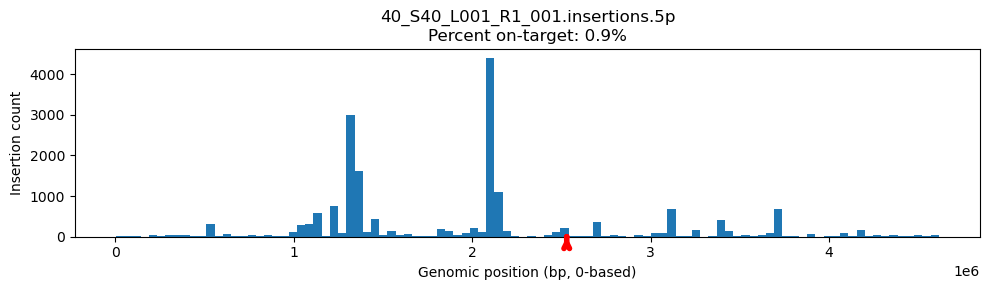

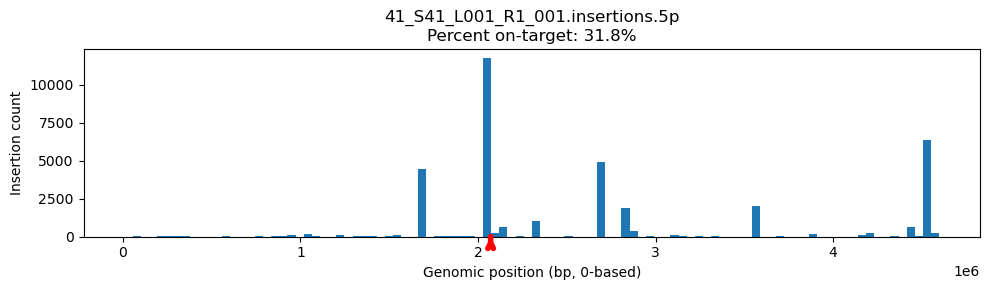

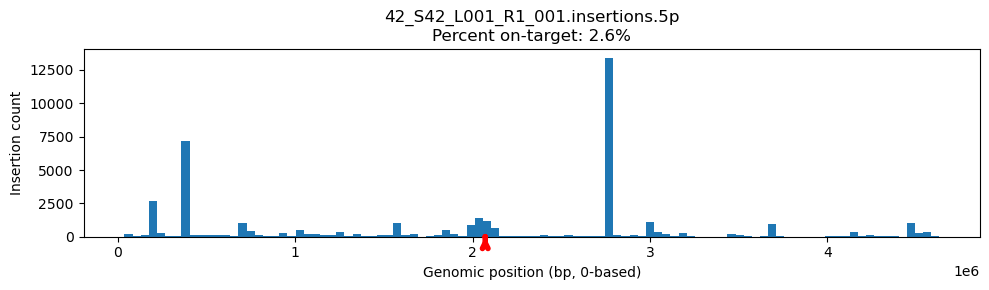

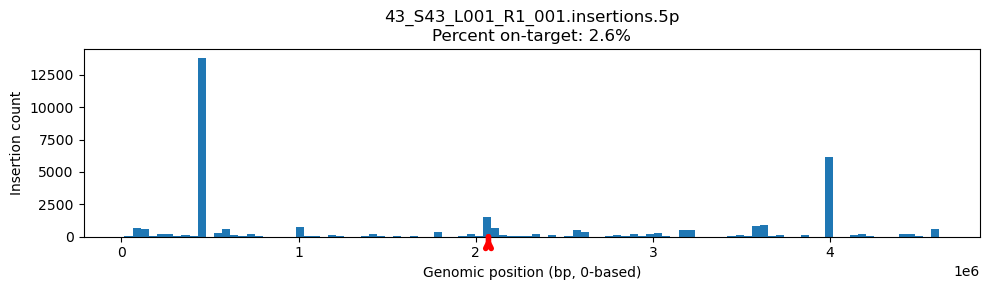

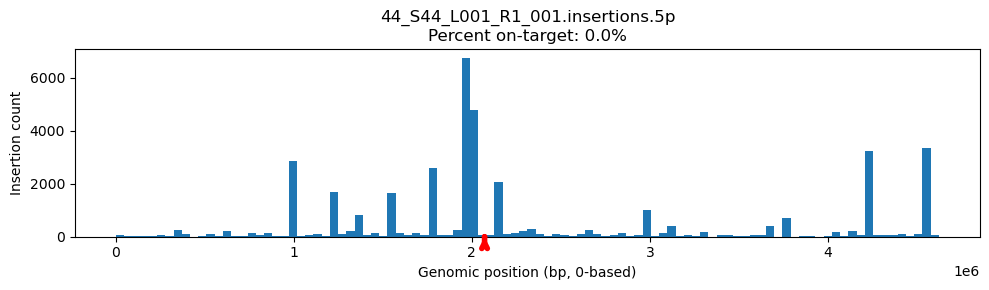

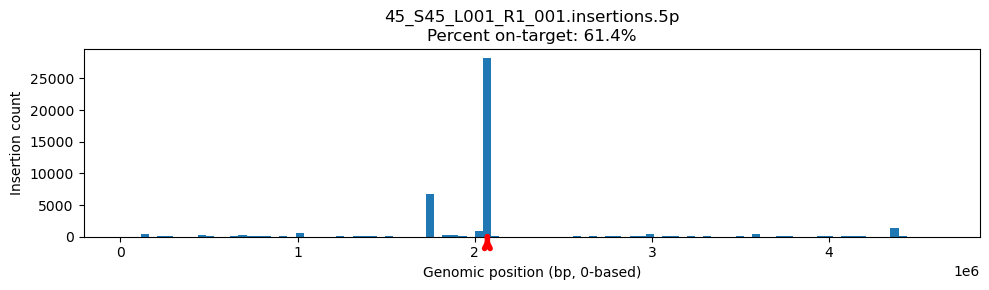

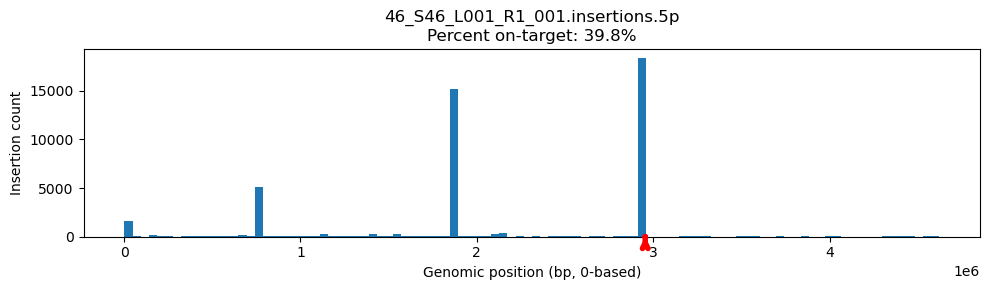

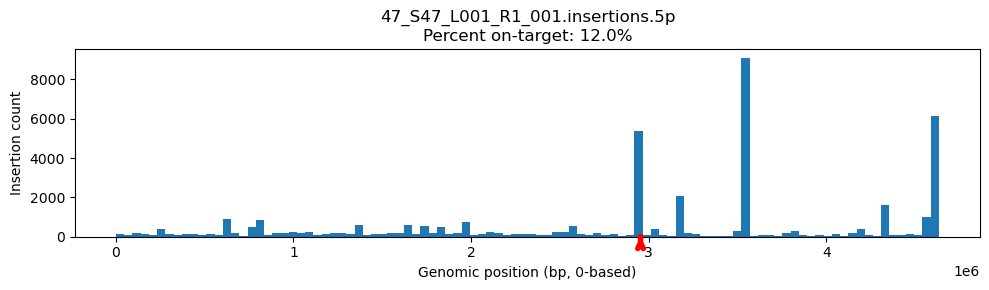

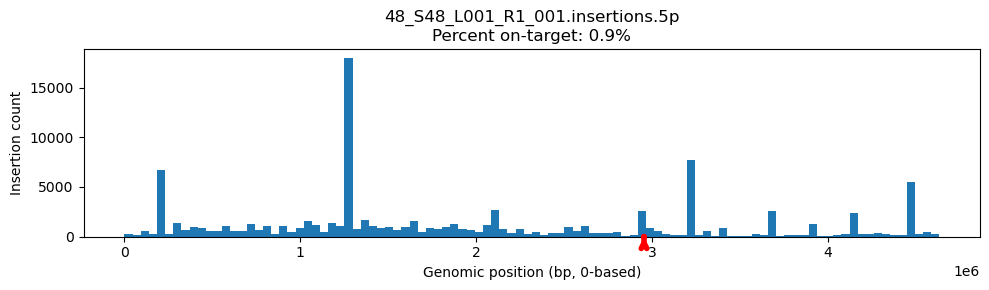

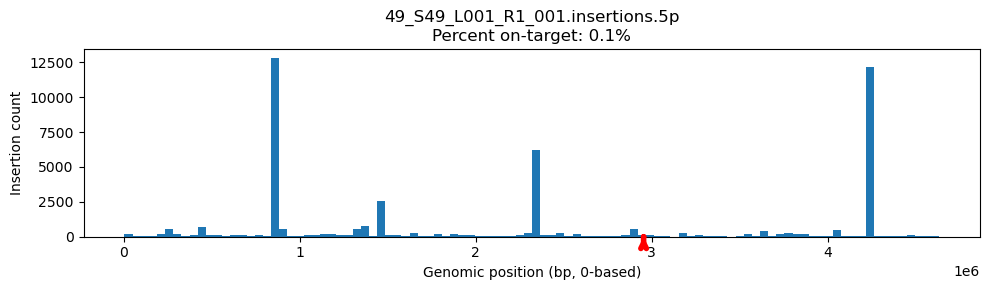

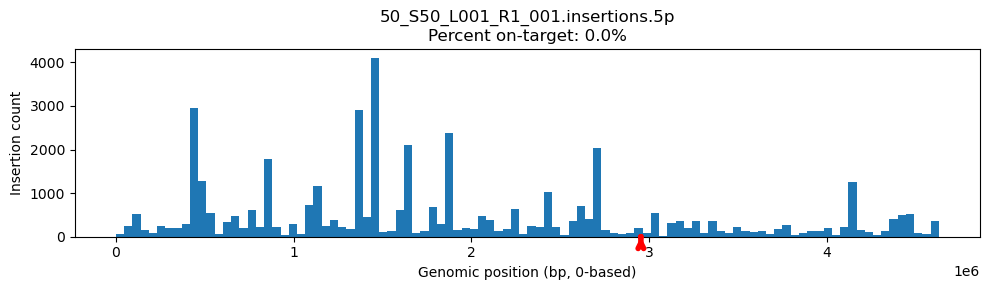

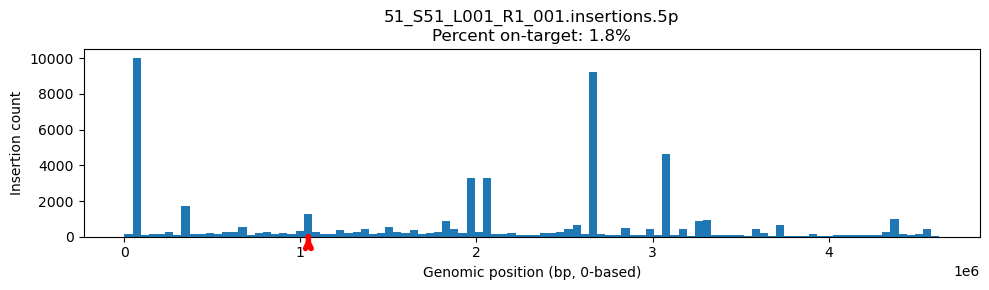

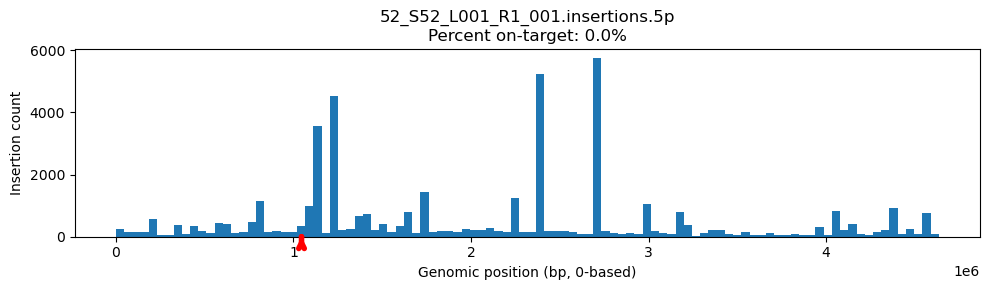

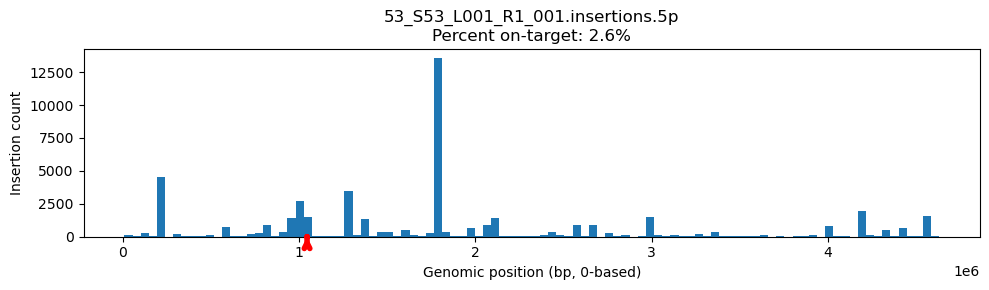

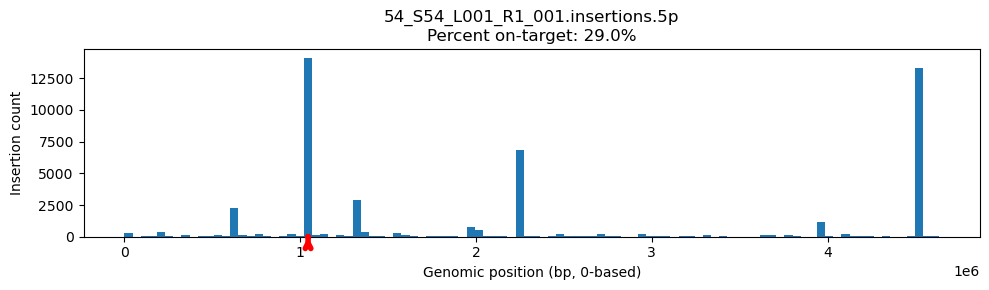

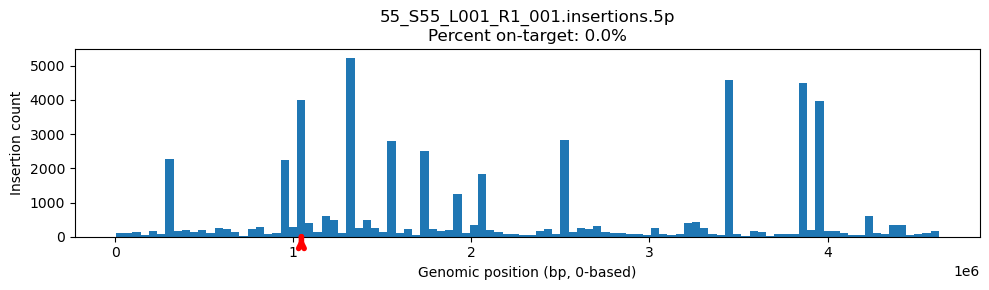

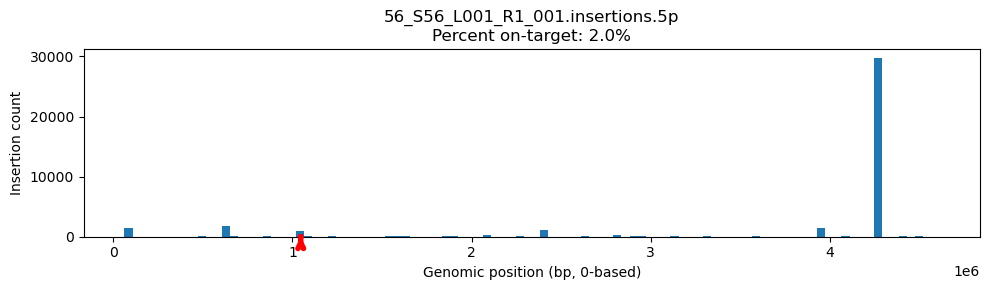

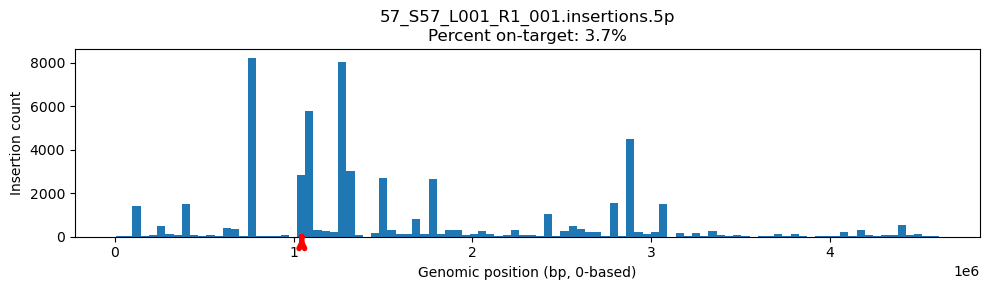

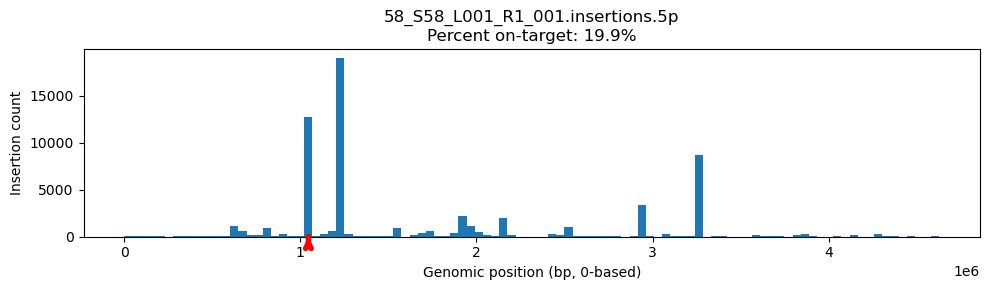

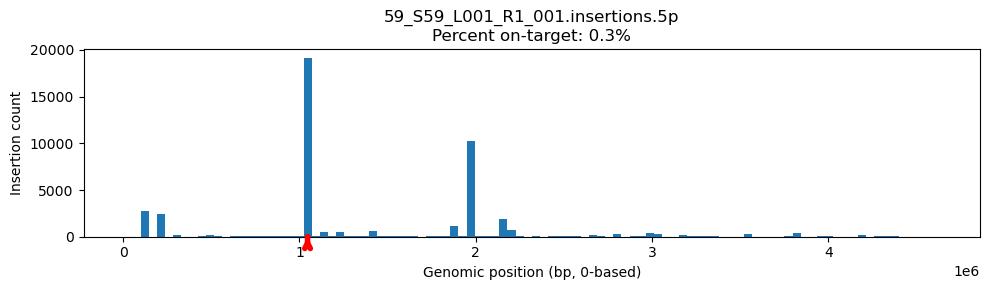

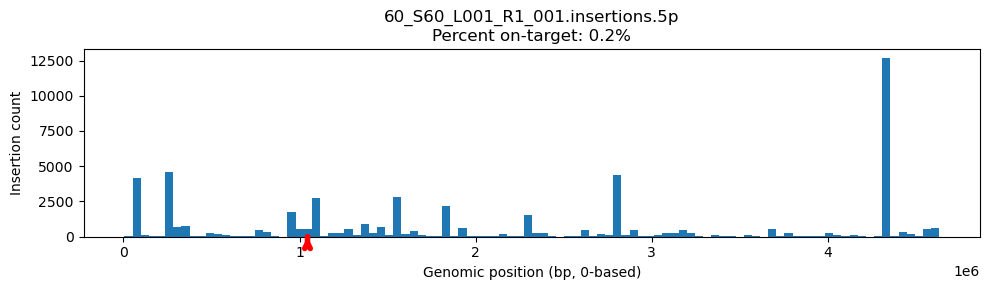

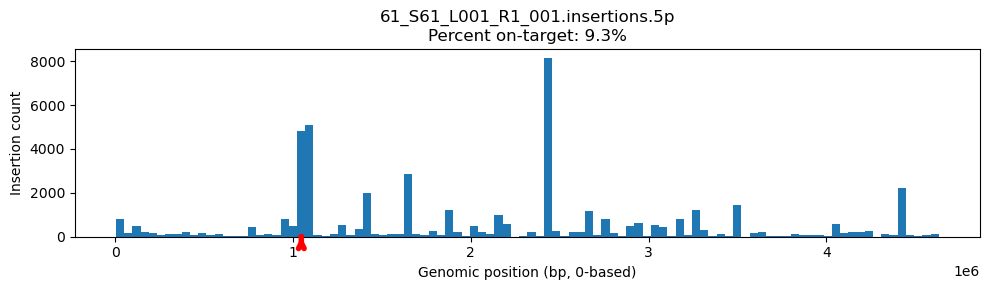

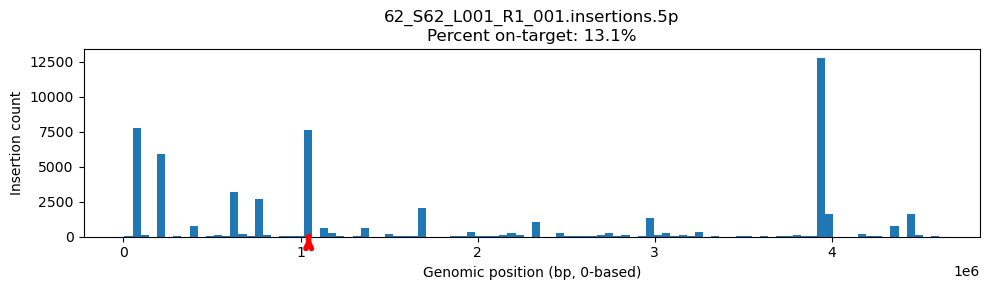

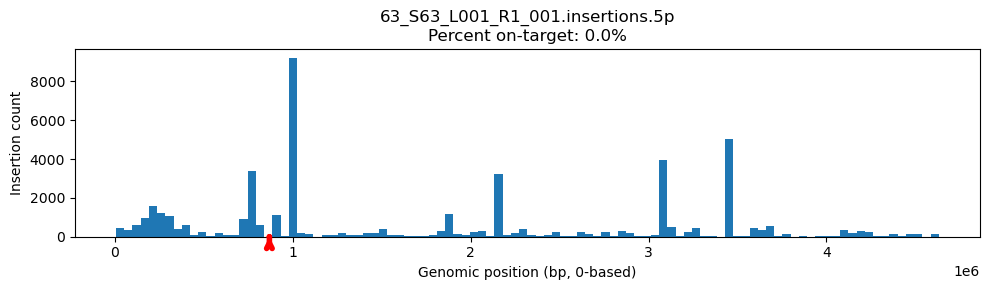

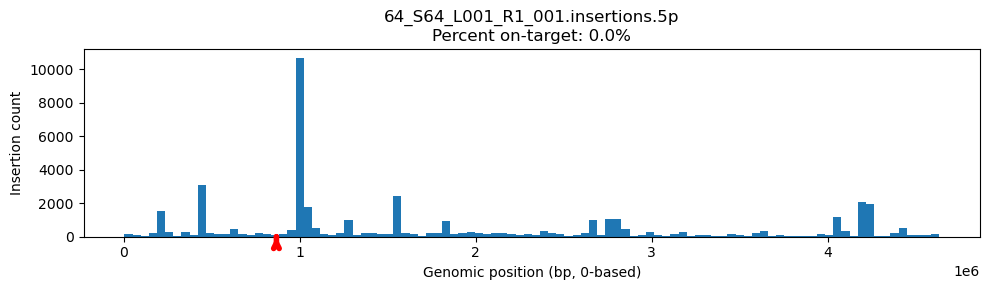

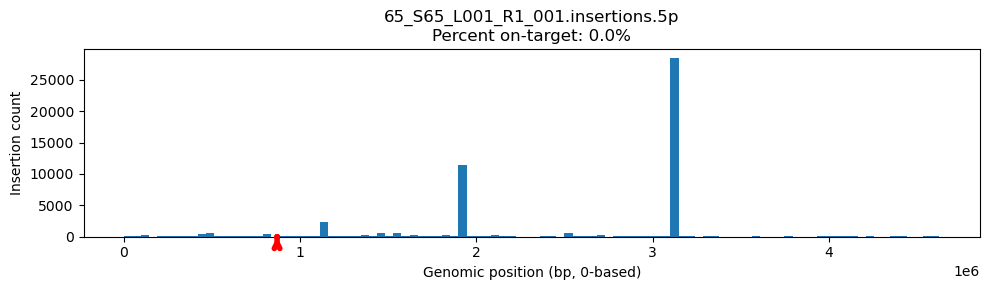

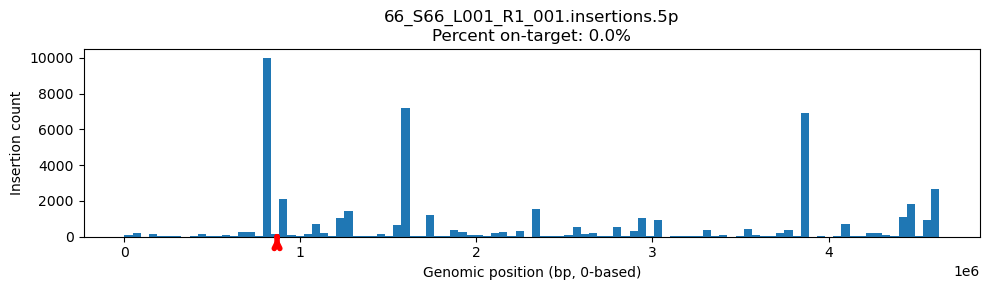

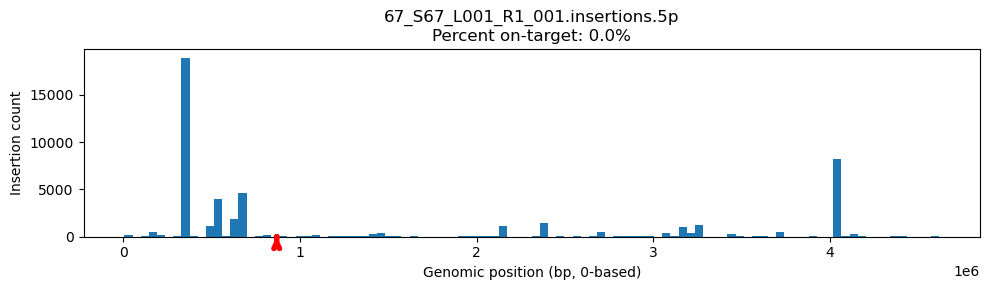

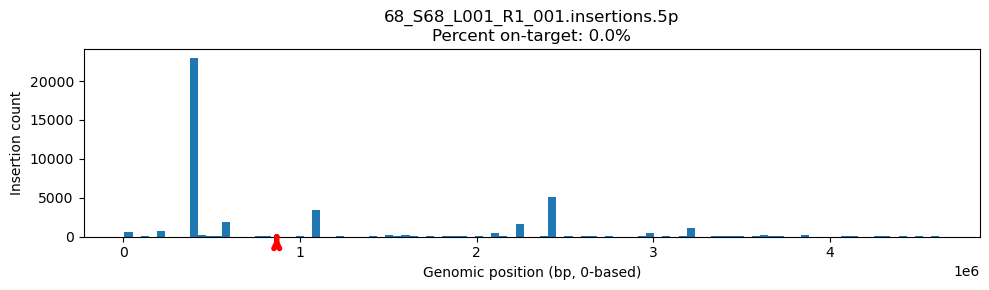

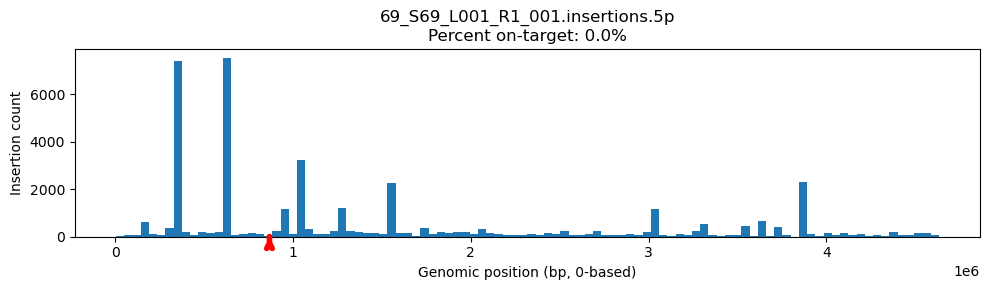

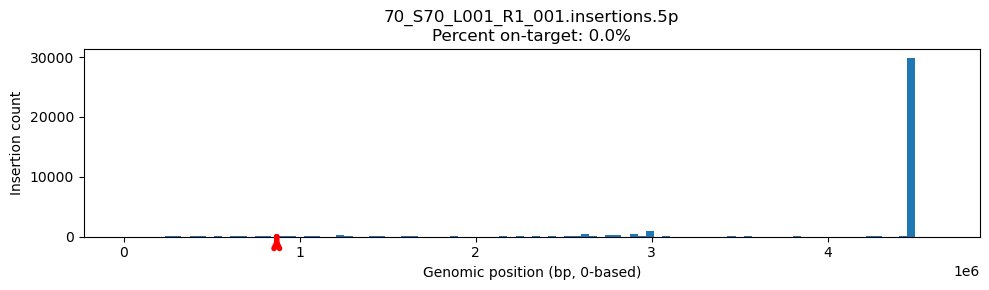

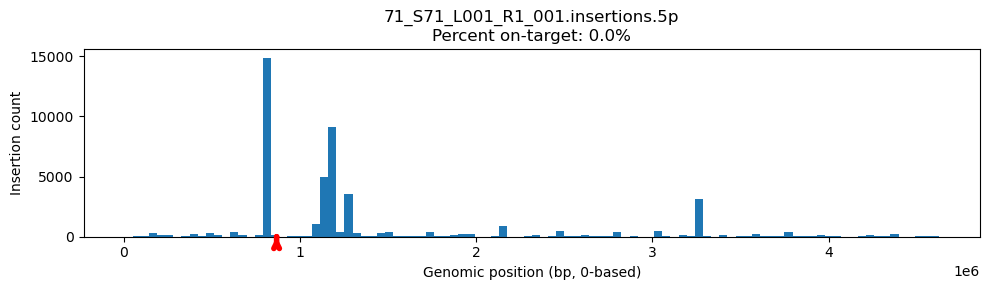

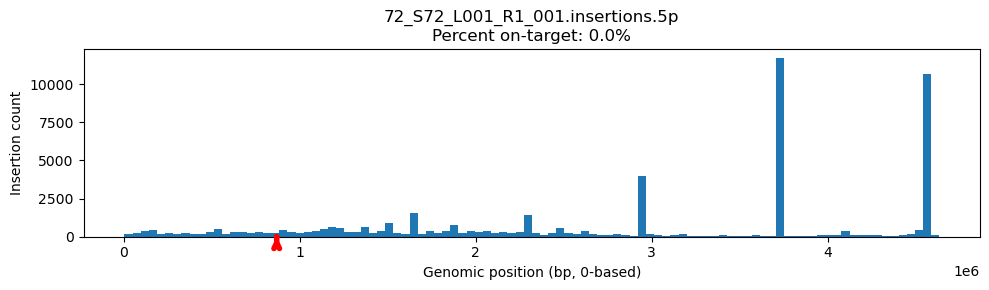

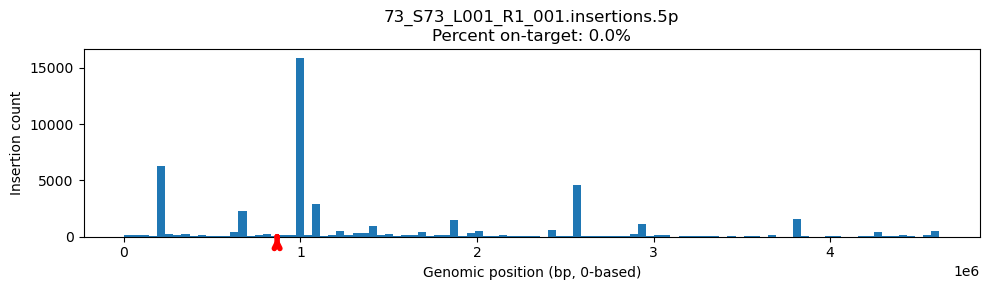

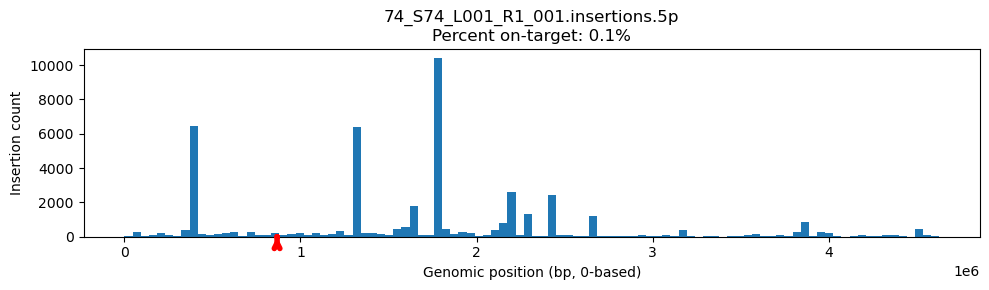

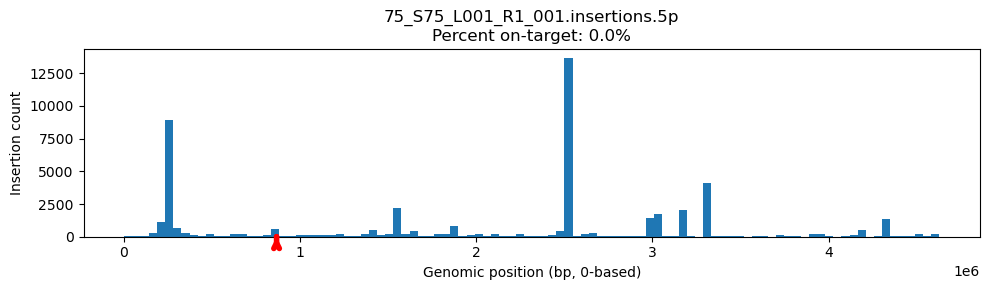

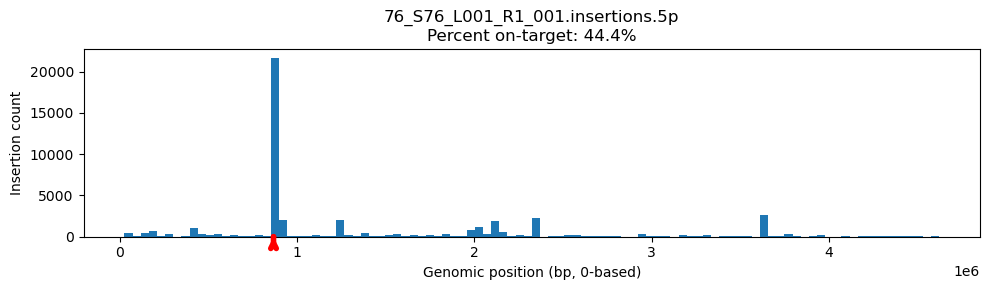

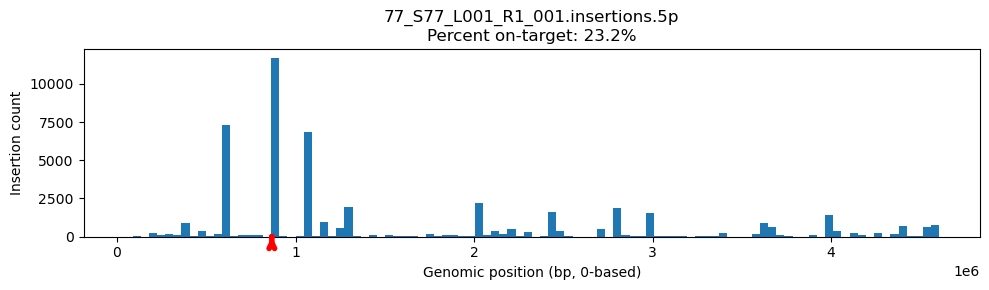

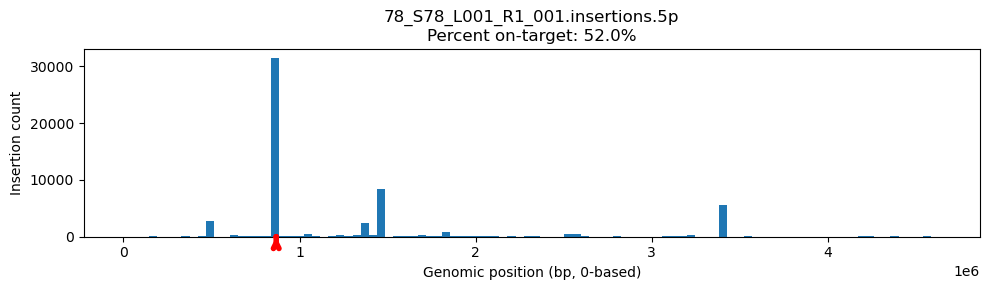

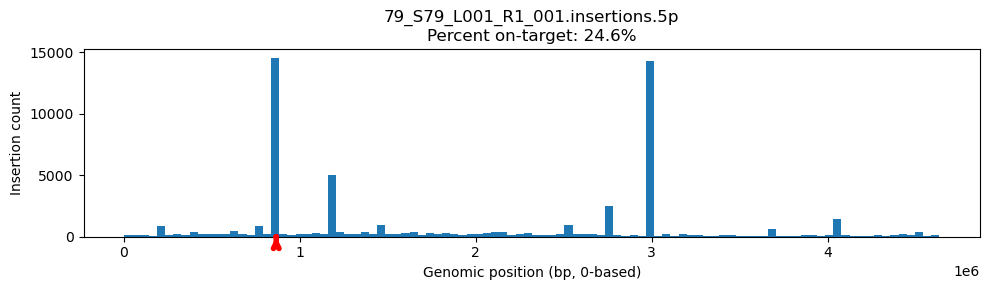

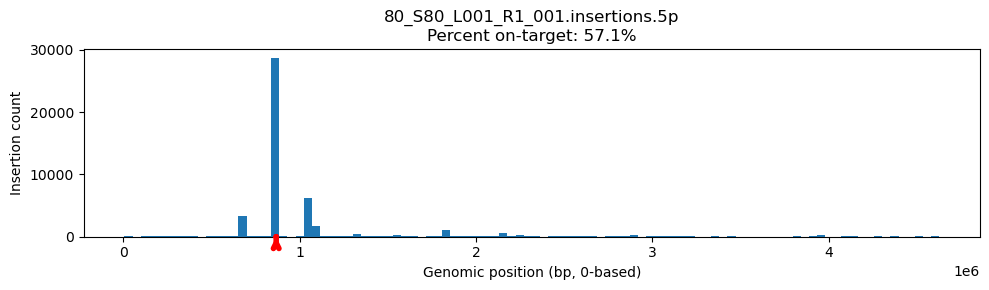

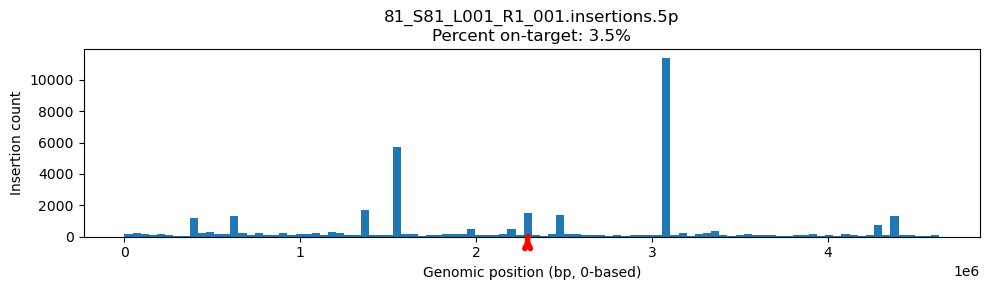

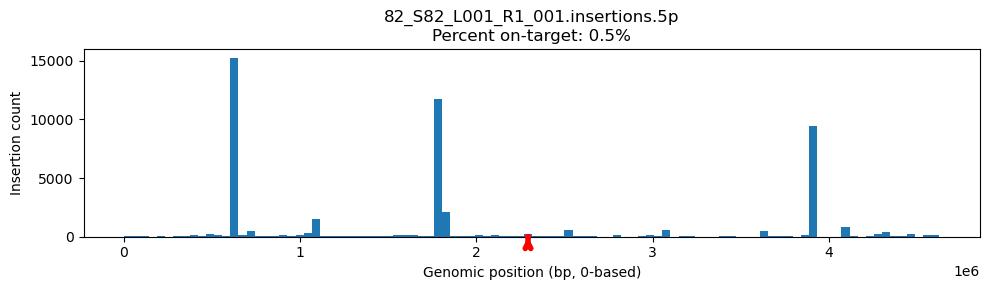

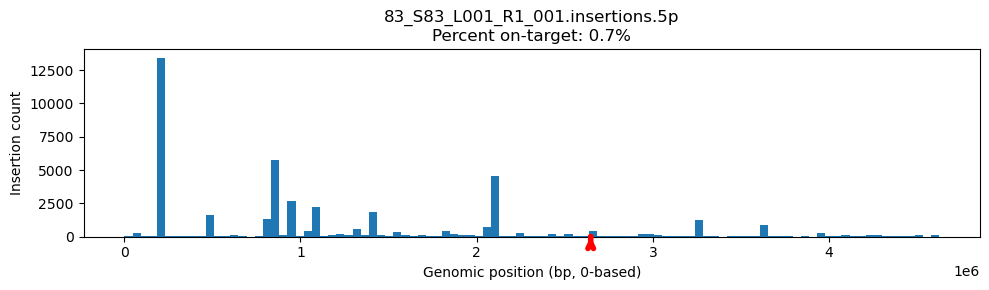

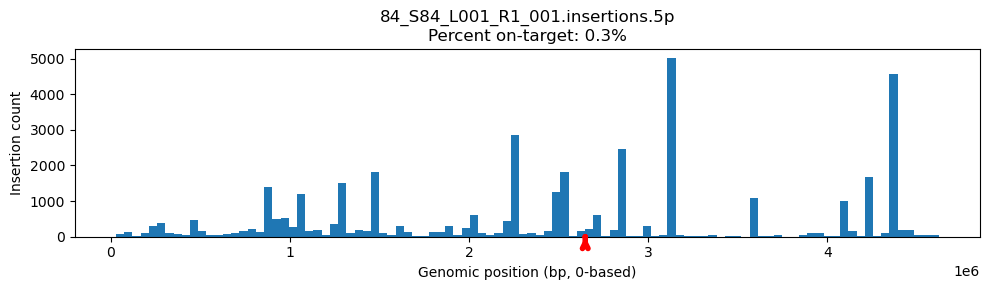

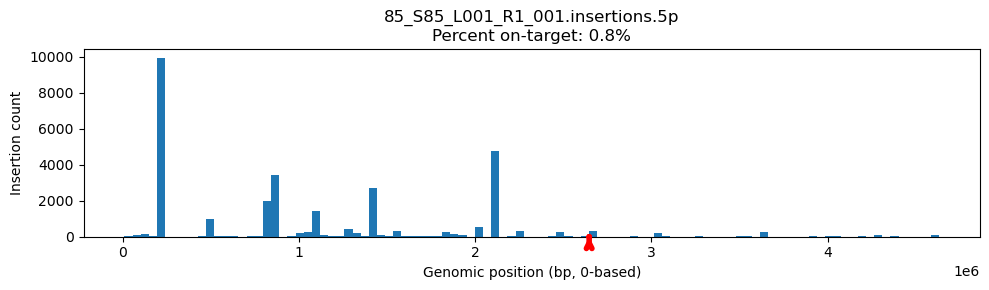

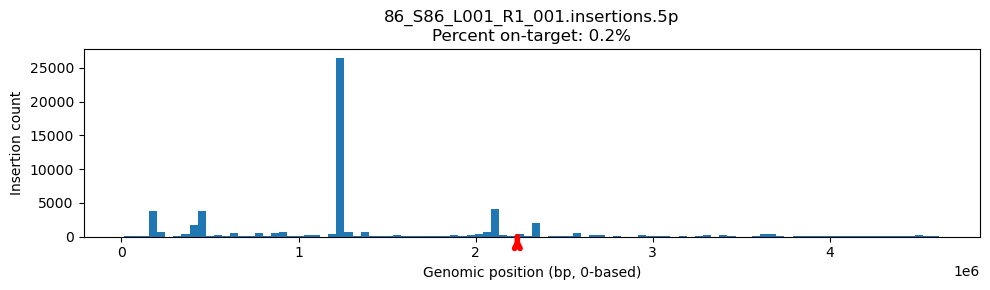

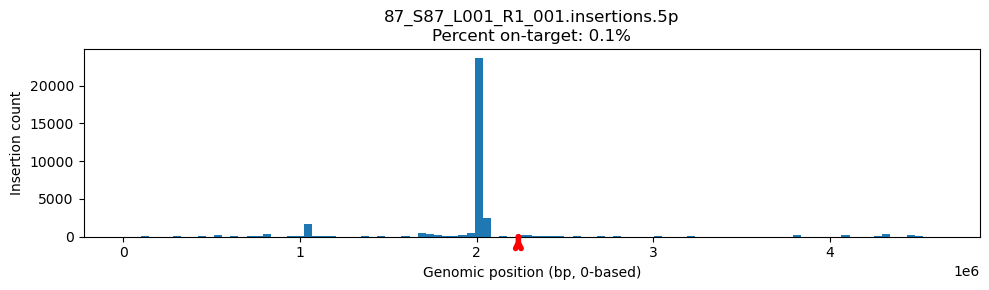

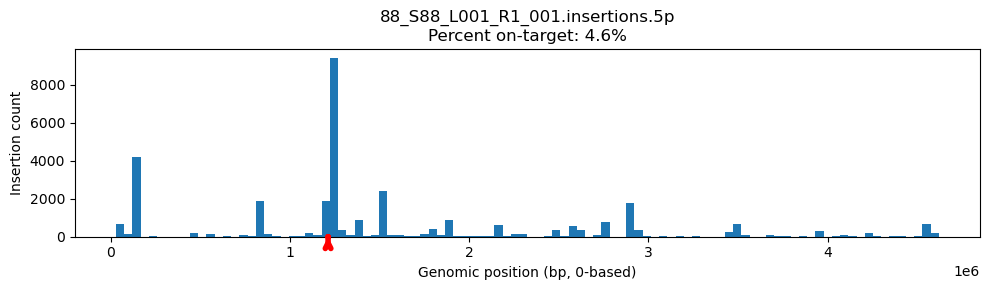

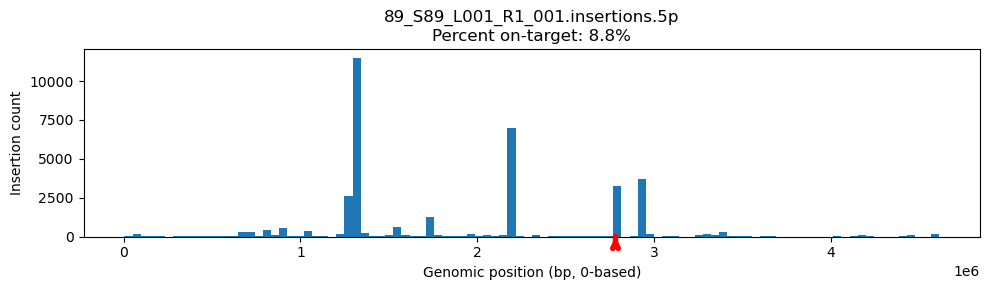

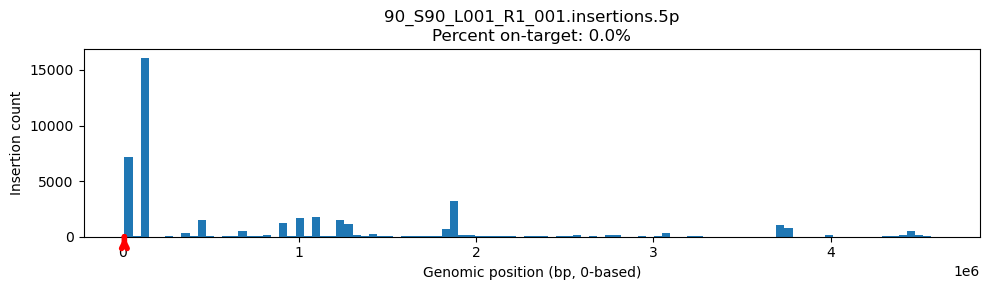

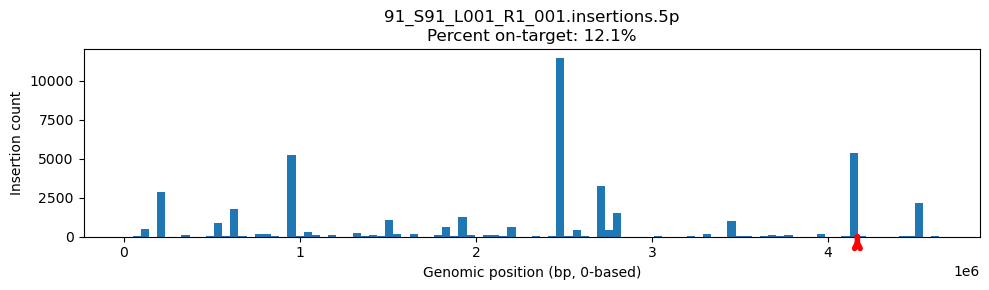

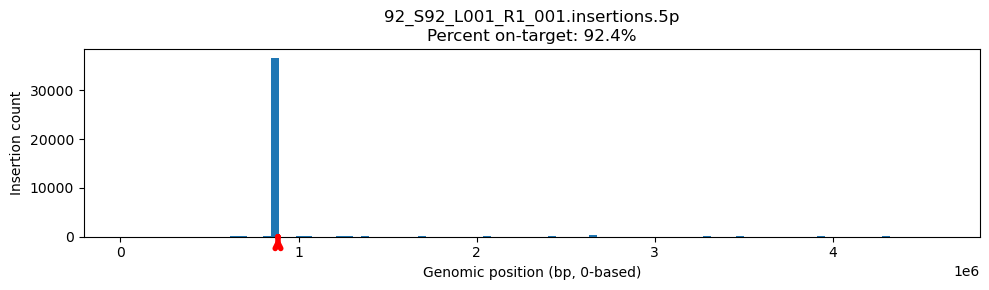

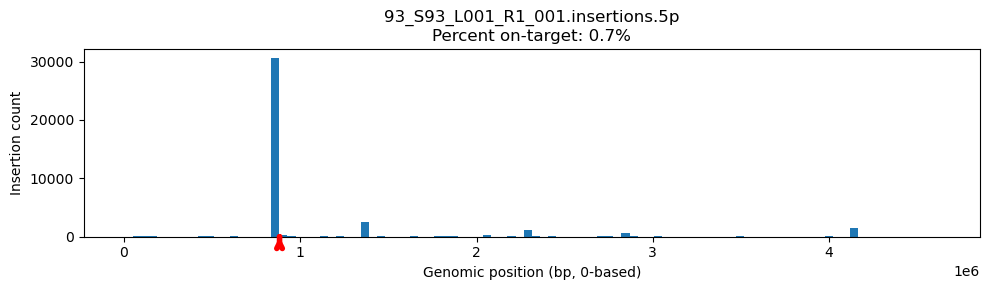

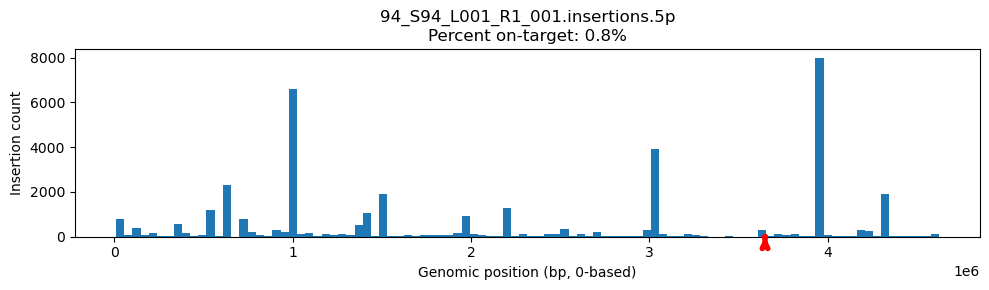

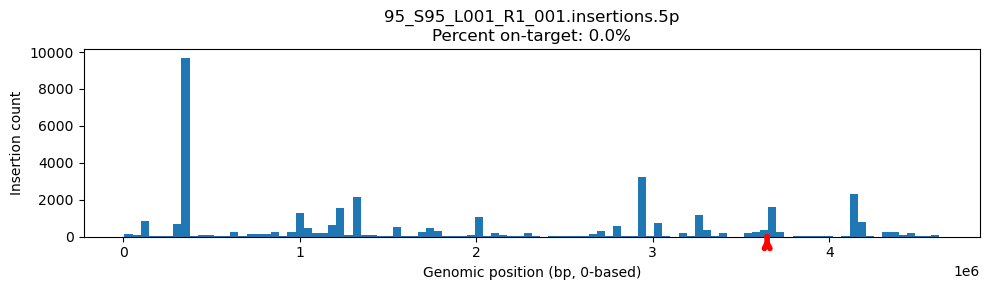

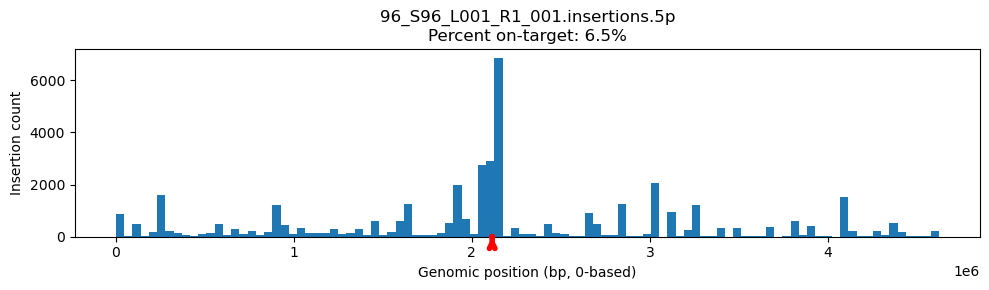

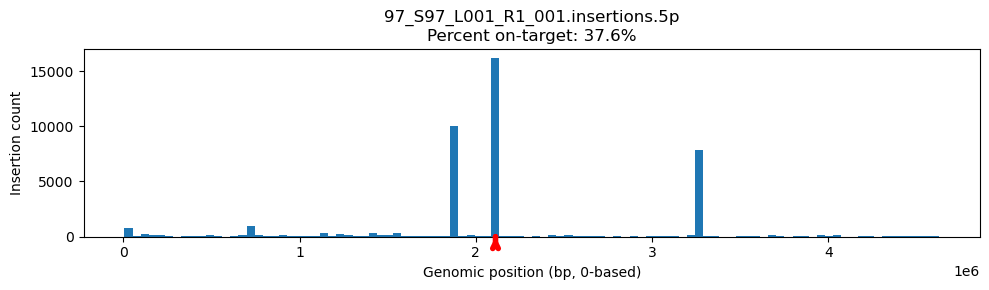

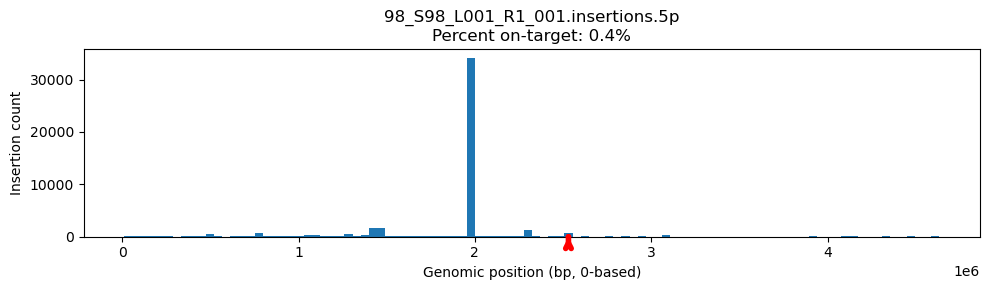

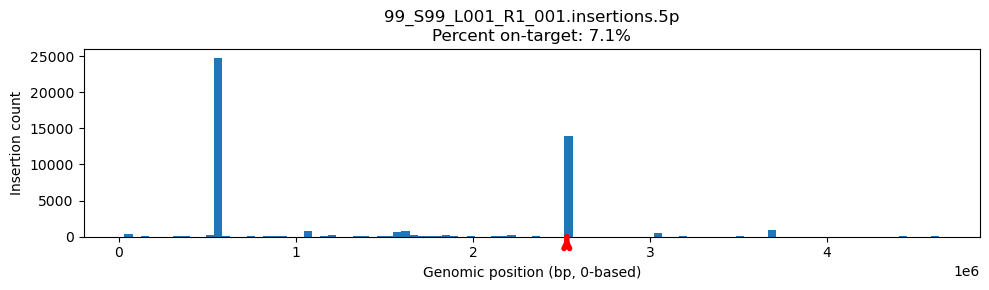

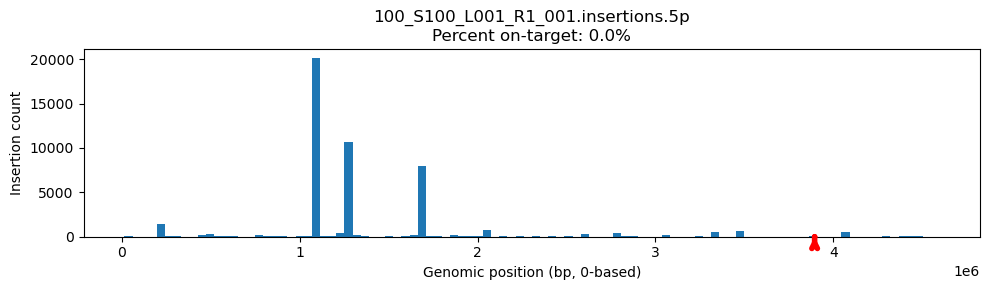

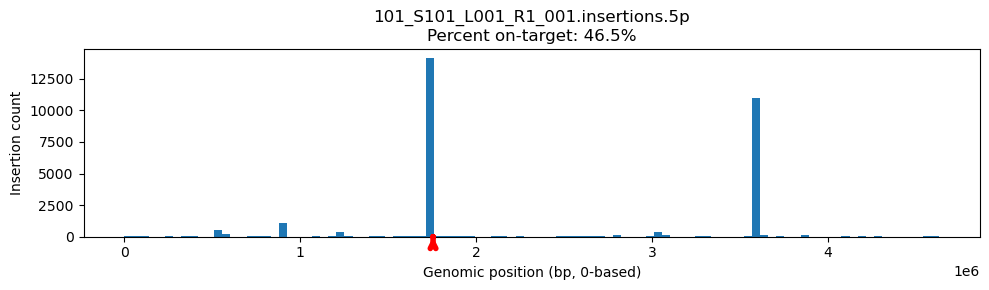

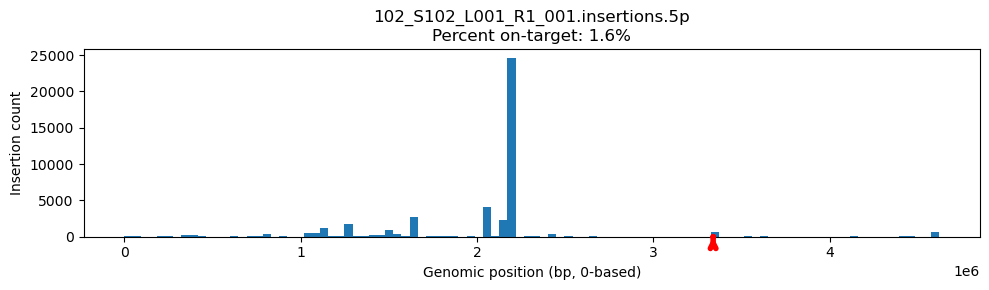

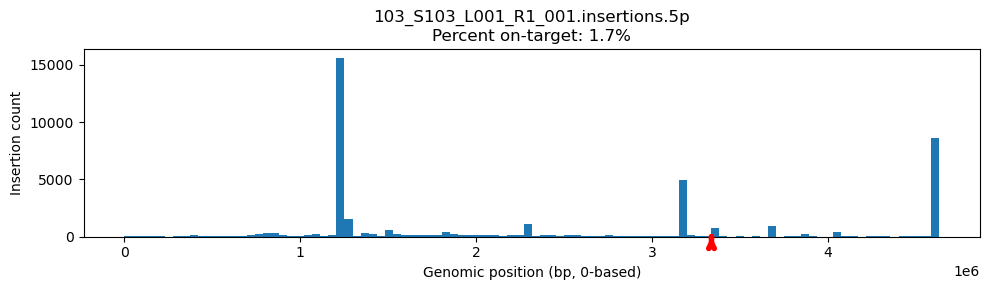

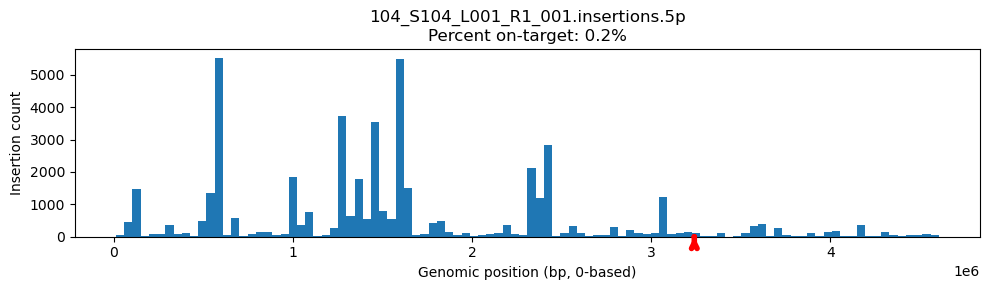

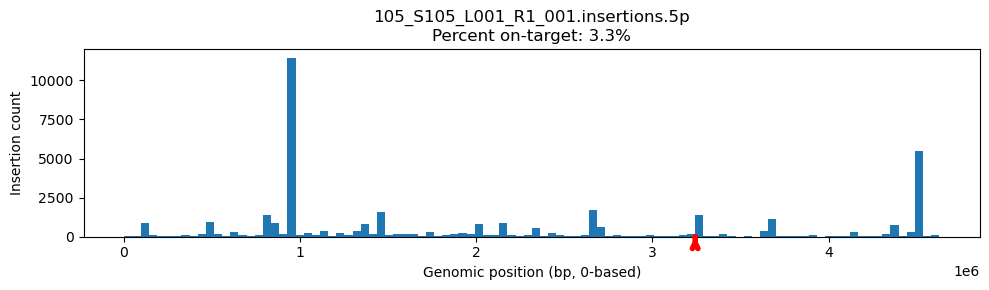

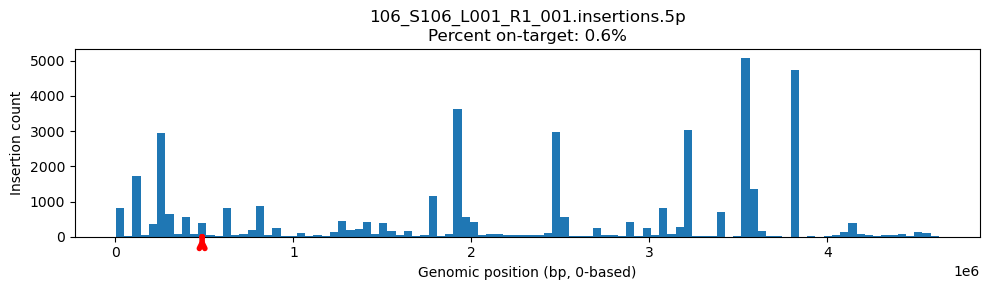

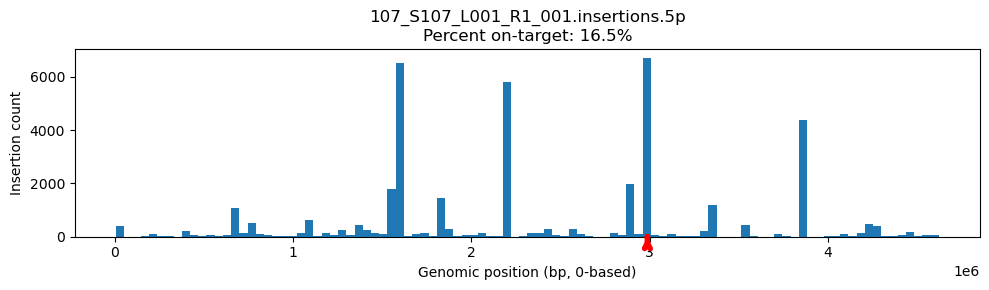

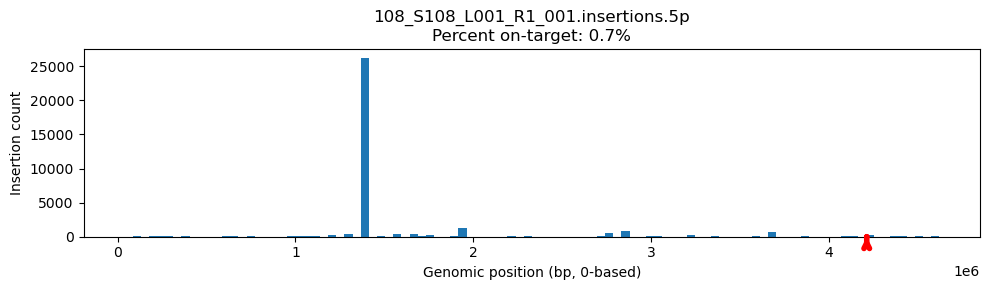

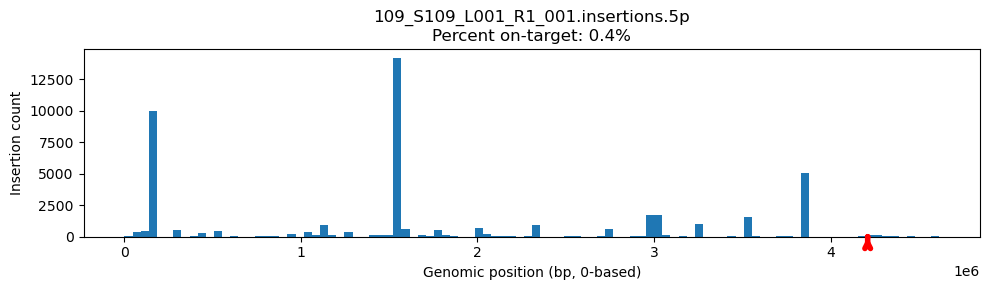

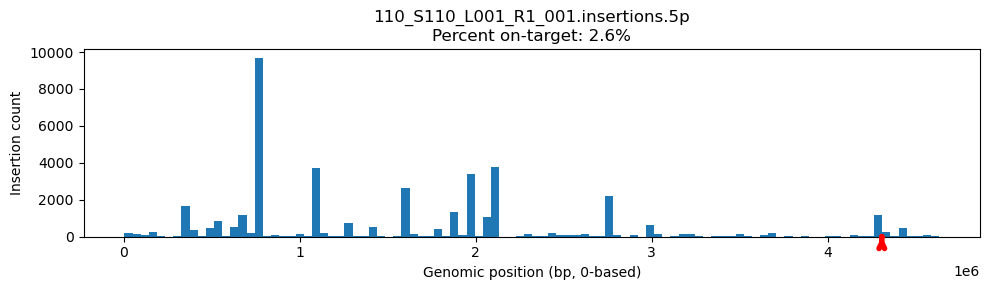

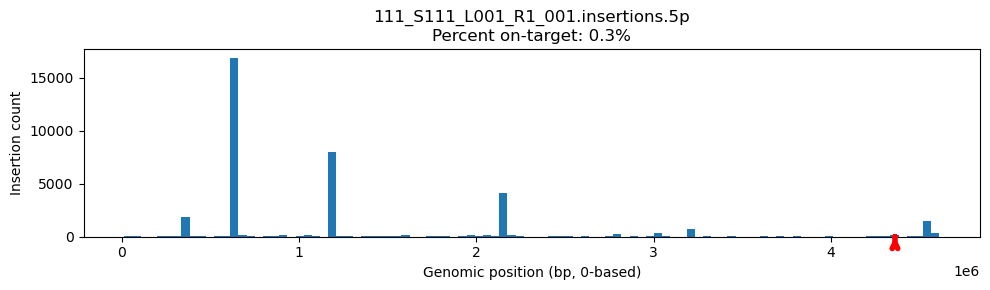

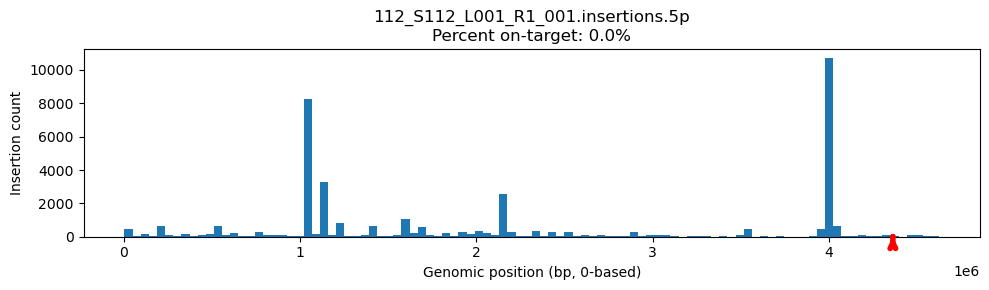

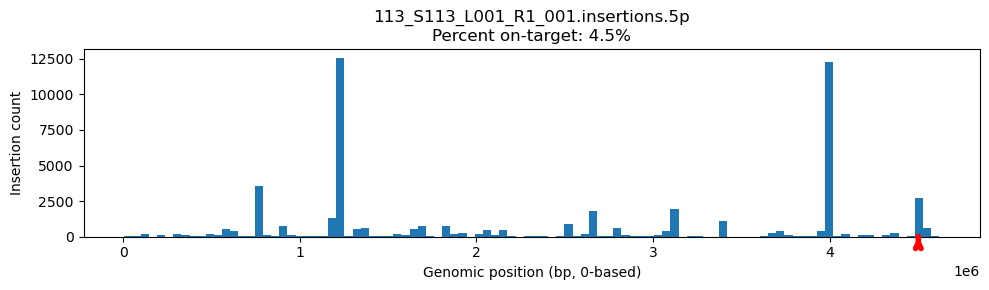

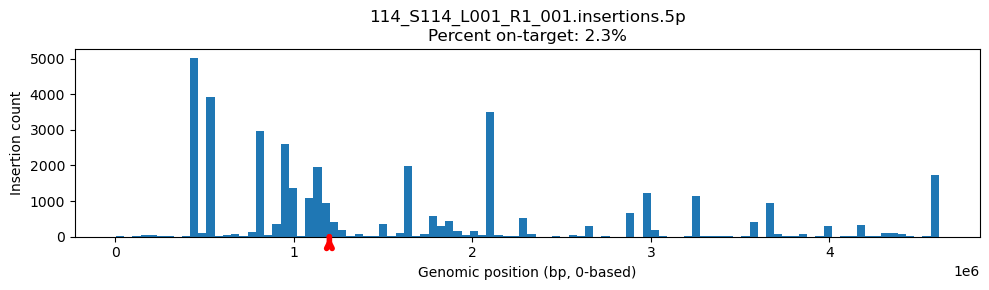

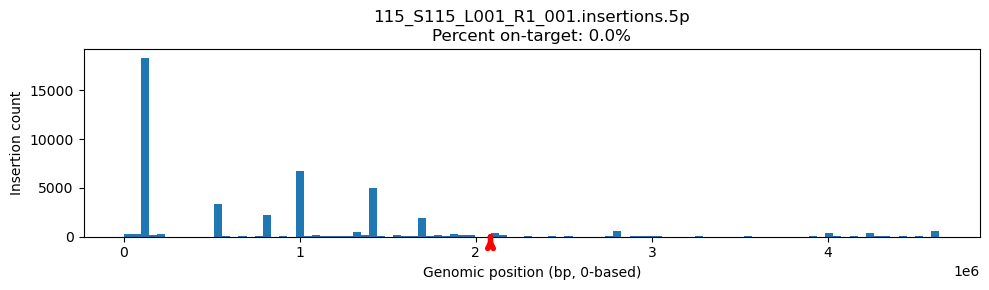

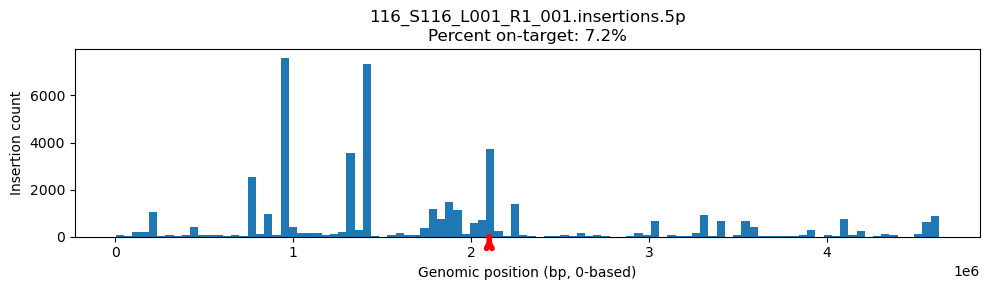

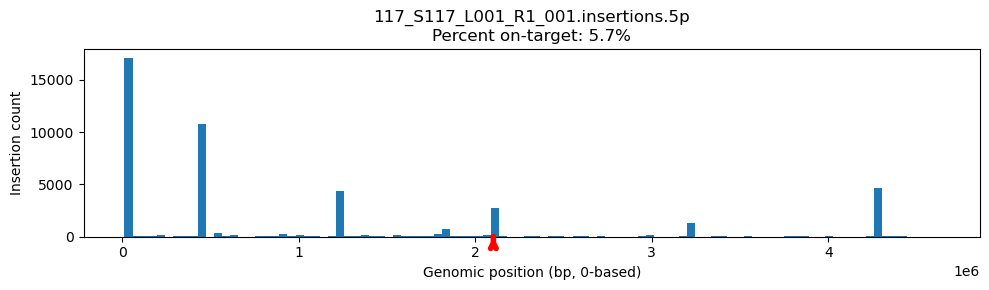

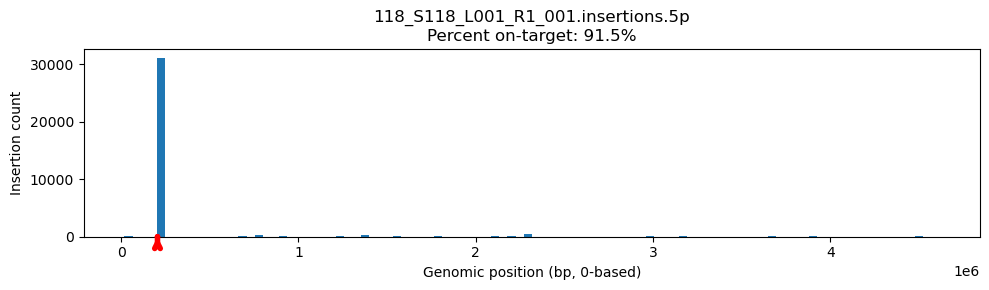

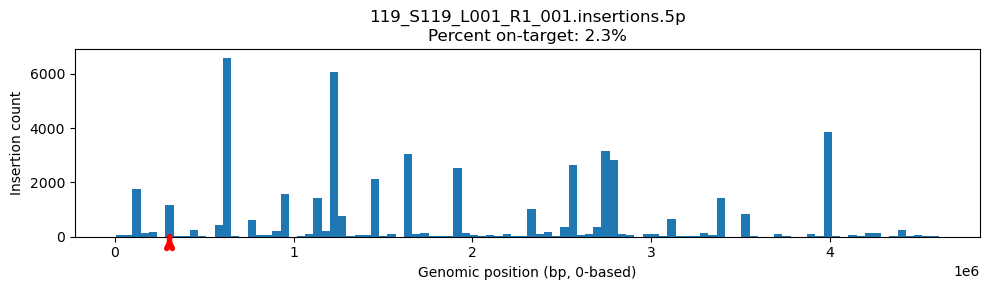

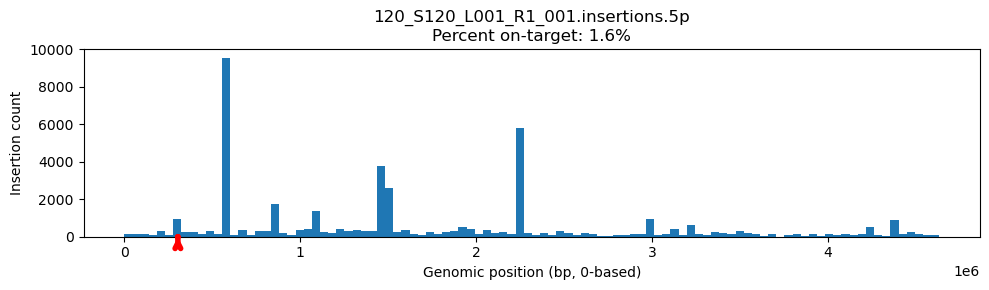

In [ ]:
bin_size = 5000               # bp per bin (adjust as needed)
ii = 0
window_bp = 200

output_folder = "Genome_plots/"

for tsv in tsv_files:
    # ---- inputs ----
    #tsv_file = "output/37_S37_L001_merged.insertions.5p.tsv"   # path to your TSV
    
    # ---- load data ----
    df = pd.read_csv(tsv, sep="\t")
    df = df[df["mapq"] >= 30]
    positions = df["ins0"]

    gmap=map_guide_to_genome(gRNA[ii],genome_sequence)
    ii+=1
    # ---- plot ----
    fig, ax = plt.subplots(figsize=(10, 3))
    
    ax.hist(
        positions,
        bins=100)
    
    ax.set_xlabel("Genomic position (bp, 0-based)")
    ax.set_ylabel("Insertion count")
    #ax.set_yscale("log")

    
    # Draw vertical lines marking guide region
    ax.axvspan(
        gmap[0]['start'],
        gmap[0]['end'],
        alpha=0.3,
        label=f"guideRNA ({gmap[0]['strand']})"
    )

    ax.annotate(
        "",                              # no text
        xy=(gmap[0]['start'], 0),             # arrow tip (on x-axis)
        xytext=(gmap[0]['start'], -0.05),      # arrow tail (slightly below axis)
        arrowprops=dict(
            arrowstyle="->",
            color="red",
            linewidth=4
        ),
        annotation_clip=False
    )
    pct_ontarget = percent_within_distance(positions, gmap[0]['start'], window_bp)
    sample_name = Path(tsv).stem
    ax.set_title(f"{sample_name}\nPercent on-target: {pct_ontarget:.1f}%")
    
    fig.tight_layout()
    
    # Create output folder if it doesn't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    fig.savefig(f"{output_folder}/{sample_name}_insertion_histogram.pdf")
    plt.show()
    plt.close()


In [8]:
from __future__ import annotations

from typing import Optional
import pandas as pd
from Bio import SeqIO

COMP = str.maketrans("ACGTacgt", "TGCAtgca")

def revcomp(seq: str) -> str:
    return seq.translate(COMP)[::-1]

def load_fasta_as_dict(fasta_path: str) -> dict[str, str]:
    seqs = {}
    for rec in SeqIO.parse(fasta_path, "fasta"):
        seqs[rec.id] = str(rec.seq).upper()
    return seqs

def extract_tsd_centered_motifs_5p(
    tsv_path: str,
    genome_fasta: str,
    tsd_len: int = 5,
    flank_left: int = 10,
    flank_right: int = 10,
    min_mapq: Optional[int] = None,
    orient_to_plus: bool = True,
) -> pd.DataFrame:
    """
    DONOR-SIDE = 5' junction reads.

    ins0 in TSV is the *reference 5' end* of the read:
      strand '+' => ins0 corresponds to LEFT edge of the TSD copy adjacent to that junction
      strand '-' => ins0 corresponds to RIGHT edge of the TSD copy adjacent to that junction

    We compute tsd_start0 per row accordingly, then extract:
      [flank_left] + [TSD (tsd_len)] + [flank_right]

    If unique_insertions=True, we dedupe by (ref, tsd_start0) (not by ins0).
    """
    df = pd.read_csv(tsv_path, sep="\t")

    required = {"ref", "ins0", "strand"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"TSV missing required columns: {sorted(missing)}")

    if min_mapq is not None:
        if "mapq" not in df.columns:
            raise ValueError("min_mapq was set but TSV has no 'mapq' column.")
        df = df[df["mapq"] >= min_mapq].copy()

    # --- Compute true TSD start (0-based) for each read, strand-aware ---
    ins0 = df["ins0"].astype(int)
    strand = df["strand"].astype(str)

    # '+' : ins0 is left edge => tsd_start = ins0
    # '-' : ins0 is right edge => tsd_start = ins0 - (tsd_len - 1)
    df["tsd_start0"] = ins0.where(strand == "+", ins0 - (tsd_len - 1))

    # Drop impossible negative coordinates
    df = df[df["tsd_start0"] >= 0].copy()

    genome = load_fasta_as_dict(genome_fasta)

    motifs = []
    keep = []

    for idx, row in df.iterrows():
        ref = str(row["ref"])
        if ref not in genome:
            continue

        tsd_start0 = int(row["tsd_start0"])
        tsd_end_excl = tsd_start0 + tsd_len

        start = tsd_start0 - flank_left
        end_excl = tsd_end_excl + flank_right

        seq = genome[ref]
        if start < 0 or end_excl > len(seq):
            continue

        motif = seq[start:end_excl]  # flank_left + tsd_len + flank_right

        if orient_to_plus and row["strand"] == "-":
            motif = revcomp(motif)

        motifs.append(motif)
        keep.append(idx)

    out = df.loc[keep].copy()
    out["motif_seq"] = motifs
    out["motif_len"] = flank_left + tsd_len + flank_right
    out["flank_left"] = flank_left
    out["tsd_len"] = tsd_len
    out["flank_right"] = flank_right
    return out


In [10]:
unique_sites = []
for ff in tsv_files:
    sites = extract_tsd_centered_motifs_5p(tsv_path=ff,
                                           genome_fasta='cJP003_assembly.fasta',
                                           tsd_len = 5,
                                           flank_left= 100,
                                           flank_right = 100,
                                           min_mapq = 30,
                                           orient_to_plus = True)   # "best_mapq" or "first"
    unique_sites.append( list(set(sites['motif_seq'])))

flat = [s for sublist in unique_sites for s in sublist]
unique_sites = flat

In [11]:
len(unique_sites)

146062

In [12]:
unique_sites

['ACAGCCAAATCATCAGTACCAGTCCTACACACGCCAGTGCGCCCCAGGTAATTTGATCAAATACTTCAATATATGCATTGATGGAGTAGTTGATCGCCCCGGAAGCATCAAACGAAGCCTGCGATGTCTGATCGGCAATCACGCCCGCCAGATAGTTCGCGATCGCGCCAGAAAGCAGCATGTAGATGCCGGTTAATACGCCGGT',
 'CCCGTTGGTGGAAACCCAGGTGGAGAAGGCGAACAGCACCATACTGATAATGGTGGTGGCAACCGGCGTCATAATATATTCGTATCCGAGGAAGGCATACGAAGCATAAGCAATAACGCGCGGCAACAGTGAGGTGAAAAAGAACAGGTTTACGAACCAGTAGGTATAGGCAGTAATAAATGCCCAACGTCCGCCCAGCGAACTT',
 'GCACTCGTTACGTAGTGATGGCGCAGGATTCTACCAGCTTGCGGGGTGTGAATACAGCTTTTCCGCGATAAAAATTGCAGCAGGCGGTCAGTTTCTTCCCGTGATTTGCGCCATGGCAATGAAAAGCCACTTCTTTCTGATTTCGGTACTCAATCGCCGGTTAACCTTGACCGCTGTACAAGGTATACTCGGACGATTTTCACTG',
 'GACCGCAACAATCTTAACAAATAATCTCAATGTTGCGCTCAGGTGAATCGCGCCAGCAAATTACGGATTATCCTGAAATGCGTTTCTCACTTGCCCGACATATGCGTAAAATGAGCGGCAGATTAAAAAAGGATAGTGACGTATGCGCATTCATATTTTAGGAATTTGTGGCACATTTATGGGCGGTCTGGCGATGCTGGCGCGC',
 'ACATAACGGTGAGGGCGTATTTCGGGGGCTGGCAAATCCACTTACCGTGACACGCTACCATTCGCTGGTGGTGGAACCTGACTCATTACCAGCGTGCTTTGACGTGACGGCCTGGAGCGAAACCCGAGAGATTATGGGGATTCGCCATCGCCAGTGGG

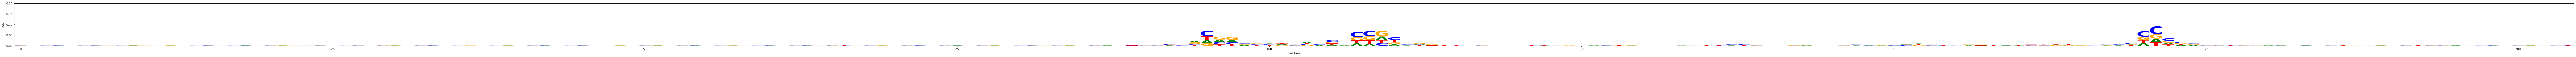

In [13]:
import pandas as pd
import numpy as np
import logomaker
import matplotlib.pyplot as plt
from collections import Counter

seqs = unique_sites

L = len(seqs[0])
assert all(len(s) == L for s in seqs), "All sequences must be the same length (aligned)."

alphabet = ["A", "C", "G", "T"]  # adjust if needed

# 1) Count matrix (positions x alphabet)
counts = []
for pos in range(L):
    c = Counter(s[pos] for s in seqs)
    counts.append({a: c.get(a, 0) for a in alphabet})

counts_df = pd.DataFrame(counts)

# 2) Convert to probability matrix
prob_df = counts_df.div(counts_df.sum(axis=1), axis=0)

# 3) Convert probs -> information content in bits (per position)
# Shannon entropy H = -sum(p*log2(p)); info = log2(K) - H, where K=len(alphabet) (DNA -> 2 bits max)
K = len(alphabet)
p = prob_df.values
with np.errstate(divide="ignore", invalid="ignore"):
    H = -np.nansum(np.where(p > 0, p * np.log2(p), 0.0), axis=1)  # length L
info = np.log2(K) - H  # bits per position

# 4) Height matrix: p(letter)*info(position)
bits_df = prob_df.mul(info, axis=0)

# 5) Plot
fig, ax = plt.subplots(figsize=(max(6, L * 0.6), 2.8))
logomaker.Logo(bits_df, ax=ax)
ax.set_xlabel("Position")
ax.set_ylabel("Bits")
#ax.set_yscale("log")
ax.set_ylim(0, 0.2)
plt.tight_layout()
fig.savefig("weblogo_bits.pdf", format="pdf", bbox_inches="tight")

plt.show()


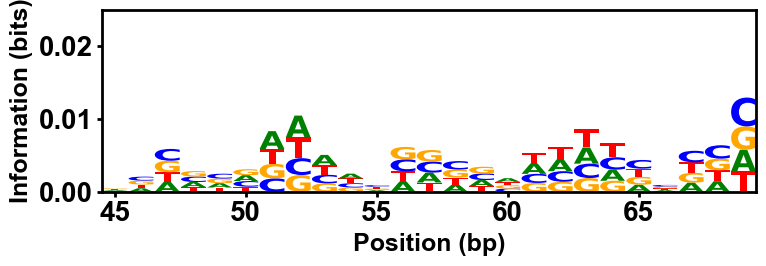

In [14]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 18,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.linewidth": 2.0,
    "xtick.major.width": 2.0,
    "ytick.major.width": 2.0,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})


logo_start = 145
logo_end   = 169
pam_pos    = 100   # this will become position 0


# Re-number positions so that 100 → 0
subset = bits_df.iloc[logo_start:logo_end + 1].copy()
subset.index = subset.index - pam_pos

import logomaker
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3))
logomaker.Logo(subset, ax=ax)

ax.set_xlabel("Position (bp)")
ax.set_ylabel("Information (bits)")  # or Count / Probability

# Y limits
ax.set_ylim(0, 0.025)

# Make spines bold (optional but matches your other figures)
for spine in ax.spines.values():
    spine.set_linewidth(2.0)

plt.tight_layout()
fig.savefig("weblogo_TniQ_polished.pdf", format="pdf", bbox_inches="tight")
plt.show()


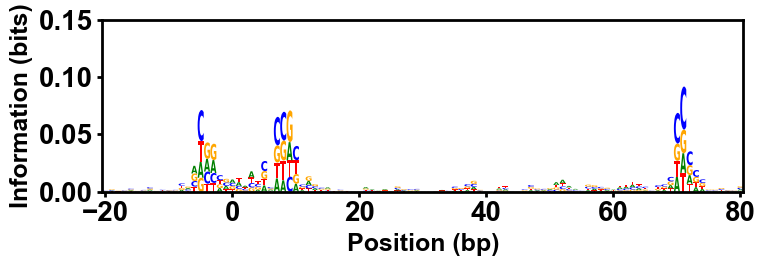

In [15]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 18,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.linewidth": 2.0,
    "xtick.major.width": 2.0,
    "ytick.major.width": 2.0,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})


logo_start = 80
logo_end   = 180
pam_pos    = 100   # this will become position 0


# Re-number positions so that 100 → 0
subset = bits_df.iloc[logo_start:logo_end + 1].copy()
subset.index = subset.index - pam_pos

import logomaker
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3))
logomaker.Logo(subset, ax=ax)

ax.set_xlabel("Position (bp)")
ax.set_ylabel("Information (bits)")  # or Count / Probability

# Y limits
ax.set_ylim(0, 0.15)

# Make spines bold (optional but matches your other figures)
for spine in ax.spines.values():
    spine.set_linewidth(2.0)

plt.tight_layout()
fig.savefig("weblogo_full_polished.pdf", format="pdf", bbox_inches="tight")
plt.show()


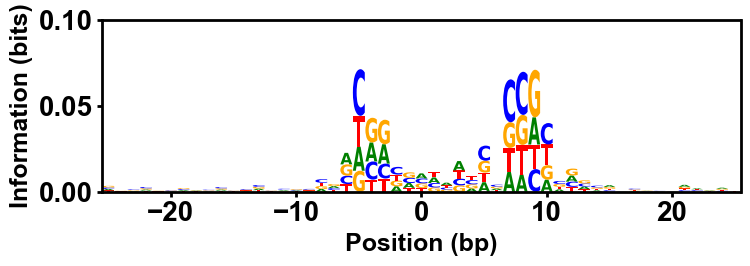

In [16]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 18,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.linewidth": 2.0,
    "xtick.major.width": 2.0,
    "ytick.major.width": 2.0,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})


logo_start = 75
logo_end   = 125
pam_pos    = 100   # this will become position 0


# Re-number positions so that 100 → 0
subset = bits_df.iloc[logo_start:logo_end + 1].copy()
subset.index = subset.index - pam_pos

import logomaker
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3))
logomaker.Logo(subset, ax=ax)

ax.set_xlabel("Position (bp)")
ax.set_ylabel("Information (bits)")  # or Count / Probability

# Y limits
ax.set_ylim(0, 0.1)

# Make spines bold (optional but matches your other figures)
for spine in ax.spines.values():
    spine.set_linewidth(2.0)

plt.tight_layout()
fig.savefig("weblogo_TSD_polished.pdf", format="pdf", bbox_inches="tight")
plt.show()